In [2]:
import requests
import locale
import matplotlib.pyplot as plt
import numpy as np

locale.setlocale(locale.LC_ALL, 'de_DE.utf8')

from IPython.display import display, Markdown, HTML

In [3]:
def display_markdown(markdown):
    display(Markdown(markdown))
    
def display_html(html):
    display(HTML(html))
    
def h(title, level=1, hid=None):
    html = "<h" + str(level)
    
    if hid:
        html += " id='" + hid + "'"
    
    html += ">"
    html += title
    html += "</h" + str(level) + ">"
    
    display_html(html)
    
def d(x):
    return locale.format("%9d", x, grouping=True)

def diff(a,b):
    return locale.format("%+9d", a-b, grouping=True)

def quot(a,b):
    if b != 0:
        return "(%+3.0f%%)" % ((a-b)/b*100)
    else:
        return " " * 7

In [7]:
import requests

from importlib import reload

import api
reload(api)

from sitemap import parse_sitemap
from api import MediaWikiSession, MediaWikiAPI
from cachecontrol import CacheControl

req_session = CacheControl(requests.session())

wb = MediaWikiAPI(MediaWikiSession("de.wikibooks.org", req_session))
wp = MediaWikiAPI(MediaWikiSession("de.wikipedia.org", req_session))

In [60]:
sitemap_code = wb.get_content("Mathe für Nicht-Freaks: Sitemap")
sitemap = parse_sitemap(sitemap_code)
sitemap["name"] = "Mathe für Nicht-Freaks"
sitemap["link"] = "Mathe für Nicht-Freaks"

In [10]:
def node_func(func):
    def result_func(node):
        if "link" in node and node["link"]:
            if id(func) not in node:
                node[id(func)] = func(node["link"])
                
            return node[id(func)]
        else:
            return None
    
    return result_func

def collect(func, node):
    result = func(node)
    if result != None:
        result = [result]
    else:
        result = []
    
    for child in node["children"]:
        result += collect(func, child)
    
    return result

def collect_pd(func, node):
    return pd.Series(collect(func, node))

def wb_views(start, end):
    return node_func(lambda x: wb.pageviews(x,start,end))

def wb_rev_count(start, end):
    return node_func(lambda x: wb.revisions_count(x,start,end))

In [63]:
@node_func
def authors_new(link):
    return wb.authors(link, "2018", "2019")

@node_func
def authors_old(link):
    return wb.authors(link, "2017", "2018")

def collect_authors(authors_func, node):
    result = authors_func(node)
    
    if not result:
        result = {}
    else:
        result = dict(result.items())
        
    for child in node["children"]:
        child_result = collect_authors(authors_func, child)
        
        for k,v in child_result.items():
            if k not in result:
                result[k] = 0
            
            result[k] += v
    
    return result

In [58]:
for k,v in sitemap.keys():
    if str(k). 

{'109.91.210.143': 3,
 '109.91.52.115': 3,
 '128.131.203.230': 6,
 '128.176.164.103': 6,
 '128.176.164.12': 3,
 '130.75.24.171': 3,
 '131.188.54.133': 3,
 '132.230.151.112': 3,
 '134.130.71.205': 3,
 '134.169.108.250': 3,
 '134.169.238.144': 9,
 '134.3.38.209': 3,
 '134.60.208.192': 3,
 '134.61.140.108': 3,
 '134.61.143.100': 3,
 '138.246.2.231': 6,
 '138.246.2.242': 12,
 '138.246.2.247': 3,
 '138.246.2.252': 9,
 '138.246.2.44': 3,
 '139.18.242.127': 3,
 '140.78.135.114': 9,
 '141.20.40.153': 3,
 '141.24.54.129': 3,
 '141.39.226.229': 3,
 '141.55.227.49': 3,
 '141.76.178.204': 3,
 '143.205.128.37': 3,
 '154.73.60.216': 1,
 '176.74.57.181': 3,
 '178.197.236.178': 3,
 '178.24.248.224': 9,
 '178.24.249.68': 24,
 '178.24.249.69': 3,
 '188.195.203.66': 3,
 '188.98.200.197': 3,
 '188.98.201.161': 6,
 '188.98.222.178': 3,
 '192.91.60.14': 3,
 '193.197.66.10': 3,
 '193.197.66.38': 18,
 '193.197.66.42': 3,
 '195.176.111.21': 3,
 '195.72.110.104': 3,
 '2.206.219.36': 3,
 '2001:16B8:2D6E:AF00:A11

In [20]:
views_new = wb_views("20180101", "20181231")
views_old = wb_views("20170101", "20171231")

In [21]:
revs_new = wb_rev_count("2018", "2019")
revs_old = wb_rev_count("2017", "2018")

In [22]:
@node_func
def views_diff(link):
    return  wb.pageviews(link,"20180101", "20181231") -  wb.pageviews(link,"20170101", "20171231")

@node_func
def revs_diff(link):
    return  wb.revisions_count(link,"2018", "2019") -  wb.revisions_count(link,"2017", "2018")

In [23]:
def wikipedia_title(x):
    params = {
        "action":"wbgetentities",
        "sites":"dewikibooks",
        "titles":x,
        "props":"sitelinks",
        "languages":"nn",
        "format":"json"
    }
    
    result = req_session.get("http://wikidata.org/w/api.php", params=params).json()["entities"]
    key, value = result.popitem()
    
    if key == "-1":
        return None
    else:
        value = value["sitelinks"]
        
        if "dewiki" in value:
            return value["dewiki"]["title"]
        else:
            return None
        
wp_title = node_func(wikipedia_title)
        
def wp_views(start, end):
    def func(link):
        res = wikipedia_title(link)
        if res != None:
            return wp.pageviews(res,start,end)
        else:
            return 0
    return node_func(func)

def wp_views_quot(start, end):
    def func(link):
        res = wikipedia_title(link)
        if res != None:
            return wb.pageviews(link,start,end) / wp.pageviews(res,start,end)
        else:
            return 0
    return node_func(func)
        
wp_new = wp_views("20180101", "20181231")
wp_old = wp_views("20170101", "20171231")

wp_quot_new = wp_views_quot("20180101", "20181231")
wp_quot_old = wp_views_quot("20170101", "20171231")

In [26]:
def toc(node, level=0):
    result = (" " * level * 4) + ("* [%s](#%s)\n" % (node["name"], node["name"]))
    
    for child in node["children"]:
        
        result += toc(child, level+1)
    
    return result

h("Inhaltsverzeichnis",1,hid="Inhaltsverzeichnis")

display_markdown(toc(sitemap))

* [Mathe für Nicht-Freaks](#Mathe für Nicht-Freaks)
    * [Über das Projekt](#Über das Projekt)
        * [Über das Projekt](#Über das Projekt)
        * [Unterstütze uns!](#Unterstütze uns!)
        * [Kopiere uns!](#Kopiere uns!)
        * [Spenden](#Spenden)
    * [Grundlagen der Mathematik](#Grundlagen der Mathematik)
        * [Was ist Mathematik?](#Was ist Mathematik?)
            * [Was ist Mathematik?](#Was ist Mathematik?)
        * [Einführung in die Logik](#Einführung in die Logik)
            * [Logik und Aussagen](#Logik und Aussagen)
            * [Junktoren](#Junktoren)
            * [Aussagenlogik](#Aussagenlogik)
            * [Wahrheitstabelle](#Wahrheitstabelle)
            * [Tautologien](#Tautologien)
            * [Quantoren](#Quantoren)
            * [Aussageform und Substitution](#Aussageform und Substitution)
            * [Prädikatenlogik](#Prädikatenlogik)
            * [Aussagen formalisieren](#Aussagen formalisieren)
            * [Aussagen negieren](#Aussagen negieren)
            * [Klassenlogik](#Klassenlogik)
            * [Gesetze der Logik](#Gesetze der Logik)
            * [Aufgaben](#Aufgaben)
        * [Beweise und Beweismethoden](#Beweise und Beweismethoden)
            * [Was sind Beweise?](#Was sind Beweise?)
            * [Direkter und indirekter Beweis](#Direkter und indirekter Beweis)
            * [Fallunterscheidung und Kontraposition](#Fallunterscheidung und Kontraposition)
            * [Notwendige und hinreichende Bedingungen](#Notwendige und hinreichende Bedingungen)
        * [Vollständige Induktion](#Vollständige Induktion)
            * [Definition und Erklärung](#Definition und Erklärung)
            * [Beispielaufgaben](#Beispielaufgaben)
        * [Mengenlehre](#Mengenlehre)
            * [Definition einer Menge](#Definition einer Menge)
            * [Mengenschreibweisen](#Mengenschreibweisen)
            * [Euler- und Venn-Diagramme](#Euler- und Venn-Diagramme)
            * [Teilmenge und echte Teilmenge](#Teilmenge und echte Teilmenge)
            * [Potenzmenge](#Potenzmenge)
            * [Leere Menge und Allklasse](#Leere Menge und Allklasse)
            * [Mengenverknüpfungen](#Mengenverknüpfungen)
            * [Durchschnitt von Mengen](#Durchschnitt von Mengen)
            * [Vereinigung von Mengen](#Vereinigung von Mengen)
            * [Differenz, symmetrische Differenz und Komplement](#Differenz, symmetrische Differenz und Komplement)
            * [Boolesche Algebra](#Boolesche Algebra)
            * [Disjunkte Mengen](#Disjunkte Mengen)
            * [Tupel und geordnetes Paar](#Tupel und geordnetes Paar)
            * [Kartesisches Produkt](#Kartesisches Produkt)
            * [Formeln der Mengenlehre](#Formeln der Mengenlehre)
            * [Russells Antinomie und Klassen](#Russells Antinomie und Klassen)
            * [Axiomatische Mengenlehre](#Axiomatische Mengenlehre)
        * [Relationen](#Relationen)
            * [Relationen](#Relationen)
            * [Binäre Relationen](#Binäre Relationen)
            * [Eigenschaften binärer Relationen](#Eigenschaften binärer Relationen)
            * [Äquivalenzrelationen](#Äquivalenzrelationen)
            * [Ordnungsrelationen](#Ordnungsrelationen)
        * [Abbildungen](#Abbildungen)
            * [Abbildungen](#Abbildungen)
            * [Verknüpfungen](#Verknüpfungen)
        * [Mächtigkeit von Mengen](#Mächtigkeit von Mengen)
            * [Mächtigkeit von Mengen](#Mächtigkeit von Mengen)
        * [Gleichungsumformungen](#Gleichungsumformungen)
            * [Gleichungsumformungen](#Gleichungsumformungen)
            * [Termumformungen](#Termumformungen)
            * [Aufgaben](#Aufgaben)
        * [Summe, Produkt und Fakultät](#Summe, Produkt und Fakultät)
            * [Summe und Produkt](#Summe und Produkt)
            * [Gaußsche Summenformel](#Gaußsche Summenformel)
            * [Geometrische Summenformel](#Geometrische Summenformel)
            * [Eigenschaften für Summe und Produkt](#Eigenschaften für Summe und Produkt)
            * [Fakultät](#Fakultät)
        * [Binomialkoeffizient](#Binomialkoeffizient)
            * [Binomialkoeffizient](#Binomialkoeffizient)
            * [Der binomische Lehrsatz](#Der binomische Lehrsatz)
            * [Rechenregeln](#Rechenregeln)
        * [Anhang](#Anhang)
            * [Wörterbuch mathematischer Begriffe](#Wörterbuch mathematischer Begriffe)
            * [Liste mathematischer Symbole](#Liste mathematischer Symbole)
            * [Zusammenfassung](#Zusammenfassung)
            * [PDF-Version (Beta)](#PDF-Version (Beta))
    * [Analysis 1](#Analysis 1)
        * [Was ist Analysis?](#Was ist Analysis?)
            * [Was ist Analysis?](#Was ist Analysis?)
            * [Wozu Analysis studieren?](#Wozu Analysis studieren?)
        * [Was sind reelle Zahlen?](#Was sind reelle Zahlen?)
            * [Was sind reelle Zahlen?](#Was sind reelle Zahlen?)
            * [Die Zahlengerade](#Die Zahlengerade)
        * [Körperaxiome](#Körperaxiome)
            * [Körperaxiome](#Körperaxiome)
            * [Folgerungen aus den Körperaxiomen](#Folgerungen aus den Körperaxiomen)
            * [Potenzen reeller Zahlen](#Potenzen reeller Zahlen)
        * [Anordnungsaxiome](#Anordnungsaxiome)
            * [Anordnungsaxiome](#Anordnungsaxiome)
            * [Folgerungen der Anordnungsaxiome](#Folgerungen der Anordnungsaxiome)
            * [Betragsfunktion, Maximum und Minimum](#Betragsfunktion, Maximum und Minimum)
            * [Intervalle](#Intervalle)
        * [Vollständigkeit reeller Zahlen](#Vollständigkeit reeller Zahlen)
            * [Intervallschachtelung mit rationaler Genauigkeit](#Intervallschachtelung mit rationaler Genauigkeit)
            * [Das archimedische Axiom](#Das archimedische Axiom)
            * [Bernoullische Ungleichung](#Bernoullische Ungleichung)
            * [Allgemeine Intervallschachtelungen](#Allgemeine Intervallschachtelungen)
        * [Die komplexen Zahlen](#Die komplexen Zahlen)
            * [Einleitung und Motivation](#Einleitung und Motivation)
            * [Definition](#Definition)
            * [Betrag und Konjugation](#Betrag und Konjugation)
            * [Polardarstellung](#Polardarstellung)
            * [Darstellung komplexwertiger Funktionen](#Darstellung komplexwertiger Funktionen)
            * [Aufgaben](#Aufgaben)
        * [Supremum und Infimum](#Supremum und Infimum)
            * [Supremum und Infimum](#Supremum und Infimum)
            * [Uneigentliches Supremum und Infimum](#Uneigentliches Supremum und Infimum)
            * [Supremum und Infimum bestimmen und beweisen](#Supremum und Infimum bestimmen und beweisen)
            * [Eigenschaften Supremum und Infimum](#Eigenschaften Supremum und Infimum)
        * [Wurzel reeller Zahlen](#Wurzel reeller Zahlen)
            * [Wurzel reeller Zahlen](#Wurzel reeller Zahlen)
            * [Lösungen von Potenzgleichungen](#Lösungen von Potenzgleichungen)
            * [Rechenregeln](#Rechenregeln)
            * [Verallgemeinerte Potenzen](#Verallgemeinerte Potenzen)
            * [Aufgaben](#Aufgaben)
        * [Folgen](#Folgen)
            * [Definition](#Definition)
            * [Explizite und rekursive Bildungsgesetze](#Explizite und rekursive Bildungsgesetze)
            * [Beispiele und Eigenschaften](#Beispiele und Eigenschaften)
            * [Aufgaben](#Aufgaben)
        * [Konvergenz und Divergenz](#Konvergenz und Divergenz)
            * [Definition Grenzwert](#Definition Grenzwert)
            * [Konvergenz und Divergenz beweisen](#Konvergenz und Divergenz beweisen)
            * [Beispiele für Grenzwerte](#Beispiele für Grenzwerte)
            * [Unbeschränkte Folgen divergieren](#Unbeschränkte Folgen divergieren)
            * [Grenzwertsätze](#Grenzwertsätze)
            * [Der Sandwichsatz](#Der Sandwichsatz)
            * [Monotoniekriterium](#Monotoniekriterium)
            * [Konvergenzbeweise rekursiver Folgen](#Konvergenzbeweise rekursiver Folgen)
            * [Aufgaben](#Aufgaben)
        * [Teilfolgen, Häufungspunkte und Cauchy-Folgen](#Teilfolgen, Häufungspunkte und Cauchy-Folgen)
            * [Teilfolgen](#Teilfolgen)
            * [Häufungspunkte von Folgen](#Häufungspunkte von Folgen)
            * [Häufungs- und Berührpunkte von Mengen](#Häufungs- und Berührpunkte von Mengen)
            * [Satz von Bolzano-Weierstraß](#Satz von Bolzano-Weierstraß)
            * [Bestimmte Divergenz](#Bestimmte Divergenz)
            * [Bestimmte Divergenz: Regeln](#Bestimmte Divergenz: Regeln)
            * [Lim sup und Lim inf](#Lim sup und Lim inf)
            * [Cauchy-Folgen](#Cauchy-Folgen)
            * [Aufgaben](#Aufgaben)
        * [Reihen](#Reihen)
            * [Begriff der Reihe](#Begriff der Reihe)
            * [Rechenregeln für Reihen](#Rechenregeln für Reihen)
            * [Teleskopsumme und Teleskopreihe](#Teleskopsumme und Teleskopreihe)
            * [Geometrische Reihe](#Geometrische Reihe)
            * [Harmonische Reihe](#Harmonische Reihe)
            * [e-Reihe](#e-Reihe)
            * [Absolute Konvergenz einer Reihe](#Absolute Konvergenz einer Reihe)
            * [Umordnungssatz für Reihen](#Umordnungssatz für Reihen)
            * [Aufgaben](#Aufgaben)
        * [Konvergenzkriterien für Reihen](#Konvergenzkriterien für Reihen)
            * [Übersicht Konvergenzkriterien](#Übersicht Konvergenzkriterien)
            * [Cauchy-Kriterium](#Cauchy-Kriterium)
            * [Trivialkriterium](#Trivialkriterium)
            * [Beschränkte Reihen und Konvergenz](#Beschränkte Reihen und Konvergenz)
            * [Majoranten- und Minorantenkriterium](#Majoranten- und Minorantenkriterium)
            * [Wurzelkriterium](#Wurzelkriterium)
            * [Quotientenkriterium](#Quotientenkriterium)
            * [Leibniz-Kriterium](#Leibniz-Kriterium)
            * [Verdichtungskriterium](#Verdichtungskriterium)
            * [Anwendung der Konvergenzkriterien](#Anwendung der Konvergenzkriterien)
            * [Aufgaben](#Aufgaben)
        * [Exponential- und Logarithmusfunktion](#Exponential- und Logarithmusfunktion)
            * [Herleitung und Definition der Exponentialfunktion](#Herleitung und Definition der Exponentialfunktion)
            * [Eigenschaften der Exponentialfunktion](#Eigenschaften der Exponentialfunktion)
            * [Logarithmusfunktion](#Logarithmusfunktion)
            * [Verallgemeinerte Potenzen](#Verallgemeinerte Potenzen)
            * [Exponential- und Logarithmusfunktion in den komplexen Zahlen](#Exponential- und Logarithmusfunktion in den komplexen Zahlen)
            * [Aufgaben](#Aufgaben)
        * [Trigonometrische und Hyperbolische Funktionen](#Trigonometrische und Hyperbolische Funktionen)
            * [Sinus und Kosinus](#Sinus und Kosinus)
            * [Eigenschaften des Sinus und Kosinus](#Eigenschaften des Sinus und Kosinus)
            * [Arkussinus und Arkuskosinus](#Arkussinus und Arkuskosinus)
            * [Tangens und Kotangens](#Tangens und Kotangens)
            * [Arkustangens und Arkuskotangens](#Arkustangens und Arkuskotangens)
            * [Sinus Hyperbolicus und Kosinus Hyperbolicus](#Sinus Hyperbolicus und Kosinus Hyperbolicus)
            * [Aufgaben](#Aufgaben)
        * [Stetigkeit](#Stetigkeit)
            * [Stetigkeit von Funktionen](#Stetigkeit von Funktionen)
            * [Folgenkriterium](#Folgenkriterium)
            * [Epsilon-Delta-Kriterium](#Epsilon-Delta-Kriterium)
            * [Grenzwert von Funktionen](#Grenzwert von Funktionen)
            * [Komposition stetiger Funktionen](#Komposition stetiger Funktionen)
            * [Stetigkeit beweisen](#Stetigkeit beweisen)
            * [Unstetigkeit beweisen](#Unstetigkeit beweisen)
            * [Zwischenwertsatz](#Zwischenwertsatz)
            * [Satz vom Minimum und Maximum](#Satz vom Minimum und Maximum)
            * [Stetigkeit der Umkehrfunktion](#Stetigkeit der Umkehrfunktion)
            * [Gleichmäßige Stetigkeit](#Gleichmäßige Stetigkeit)
            * [Lipschitz-Stetigkeit](#Lipschitz-Stetigkeit)
            * [Aufgaben](#Aufgaben)
        * [Ableitung](#Ableitung)
            * [Ableitung](#Ableitung)
            * [Ableitungsregeln](#Ableitungsregeln)
            * [Spezielle Ableitungsregeln](#Spezielle Ableitungsregeln)
            * [Ableitung der Umkehrfunktion](#Ableitung der Umkehrfunktion)
            * [Beispiele für Ableitungen](#Beispiele für Ableitungen)
            * [Ableitung höherer Ordnung](#Ableitung höherer Ordnung)
            * [Satz von Rolle](#Satz von Rolle)
            * [Mittelwertsatz](#Mittelwertsatz)
            * [Konstanzkriterium](#Konstanzkriterium)
            * [Monotoniekriterium](#Monotoniekriterium)
            * [Ableitung und lokale Extrema](#Ableitung und lokale Extrema)
            * [Regel von L'Hospital](#Regel von L'Hospital)
            * [Übersicht: Stetigkeit und Differenzierbarkeit](#Übersicht: Stetigkeit und Differenzierbarkeit)
            * [Aufgaben 1](#Aufgaben 1)
            * [Aufgaben 2](#Aufgaben 2)
            * [Aufgaben 3](#Aufgaben 3)
            * [Aufgaben 4](#Aufgaben 4)
        * [Integrale](#Integrale)
            * [Das Integral](#Das Integral)
            * [Riemannintegral](#Riemannintegral)
            * [Eigenschaften des Riemannintegrals](#Eigenschaften des Riemannintegrals)
            * [Regelintegral](#Regelintegral)
            * [Mittelwertsatz für Integrale](#Mittelwertsatz für Integrale)
            * [Hauptsatz der Differential- und Integralrechnung](#Hauptsatz der Differential- und Integralrechnung)
            * [Substitutionsregel](#Substitutionsregel)
            * [Partielle Integration](#Partielle Integration)
            * [Uneigentliche Integrale](#Uneigentliche Integrale)
            * [Beispiele für Integrale](#Beispiele für Integrale)
            * [Aufgaben](#Aufgaben)
    * [Lineare Algebra 1](#Lineare Algebra 1)
        * [Einführung in die lineare Algebra](#Einführung in die lineare Algebra)
            * [Was ist Algebra?](#Was ist Algebra?)
            * [Eigenschaften algebraischer Strukturen](#Eigenschaften algebraischer Strukturen)
            * [Gruppen](#Gruppen)
            * [Ringe](#Ringe)
            * [Körper](#Körper)
            * [Übersicht zu algebraischer Strukturen](#Übersicht zu algebraischer Strukturen)
            * [Vektorbegriff aus der Schule](#Vektorbegriff aus der Schule)
        * [Vektorräume](#Vektorräume)
            * [Einführung in den Vektorraum](#Einführung in den Vektorraum)
            * [Vektorraum](#Vektorraum)
            * [Eigenschaften von Vektorräumen](#Eigenschaften von Vektorräumen)
            * [Beweise für Vektorräume führen](#Beweise für Vektorräume führen)
            * [Der Körper als Vektorraum](#Der Körper als Vektorraum)
            * [Koordinatenräume](#Koordinatenräume)
            * [Folgenräume](#Folgenräume)
            * [Funktionsräume](#Funktionsräume)
            * [Untervektorraum](#Untervektorraum)
            * [Vereinigung und Durchschnitt von Vektorräumen](#Vereinigung und Durchschnitt von Vektorräumen)
            * [Nebenklassen eines Vektorraums](#Nebenklassen eines Vektorraums)
            * [Summe und direkte Summe](#Summe und direkte Summe)
            * [Faktorraum](#Faktorraum)
            * [Konstruierte direkte Summe](#Konstruierte direkte Summe)
        * [Linearkombinationen, Erzeugendensystem und Basis](#Linearkombinationen, Erzeugendensystem und Basis)
            * [Linearkombinationen](#Linearkombinationen)
            * [Spann einer Menge](#Spann einer Menge)
            * [Erzeugendensystem](#Erzeugendensystem)
            * [Lineare Unabhängigkeit von Vektoren](#Lineare Unabhängigkeit von Vektoren)
            * [Basis eines Vektorraums](#Basis eines Vektorraums)
            * [Dimension eines Vektorraums](#Dimension eines Vektorraums)
        * [Lineare Abbildungen](#Lineare Abbildungen)
            * [Lineare Abbildungen](#Lineare Abbildungen)
            * [Eigenschaften linearer Abbildungen](#Eigenschaften linearer Abbildungen)
            * [Prinzip der linearen Fortsetzung](#Prinzip der linearen Fortsetzung)
            * [Beispiele für lineare Abbildungen](#Beispiele für lineare Abbildungen)
            * [Bild einer linearen Abbildung](#Bild einer linearen Abbildung)
            * [Kern einer linearen Abbildung](#Kern einer linearen Abbildung)
            * [Arten linearer Abbildungen](#Arten linearer Abbildungen)
            * [Vektorraum linearer Abbildungen](#Vektorraum linearer Abbildungen)
            * [Aufgaben](#Aufgaben)
        * [Matrizen](#Matrizen)
            * [Definition der Matrix](#Definition der Matrix)
            * [Arten von Matrizen](#Arten von Matrizen)
            * [Einführung in Abbildungsmatrizen und Rechnen mit Matrizen](#Einführung in Abbildungsmatrizen und Rechnen mit Matrizen)
            * [Abbildungsmatrizen](#Abbildungsmatrizen)
            * [Gleichheit, Addition und Skalarmultiplikation von Matrizen](#Gleichheit, Addition und Skalarmultiplikation von Matrizen)
            * [Matrizenmultiplikation](#Matrizenmultiplikation)
            * [Basiswechselmatrizen](#Basiswechselmatrizen)
            * [Rang einer Matrix](#Rang einer Matrix)
            * [Zeilenstufenform einer Matrix](#Zeilenstufenform einer Matrix)
            * [Inverse Matrizen](#Inverse Matrizen)
            * [Aufgaben](#Aufgaben)
        * [Isomorphiesatz und Dimensionsformel](#Isomorphiesatz und Dimensionsformel)
            * [Intuition hinter Isomorphiesatz und Dimensionsformel](#Intuition hinter Isomorphiesatz und Dimensionsformel)
            * [Isomorphiesatz](#Isomorphiesatz)
            * [Dimensionsformel](#Dimensionsformel)
        * [Gleichungssysteme und Matrizen](#Gleichungssysteme und Matrizen)
            * [Einführendes Beispiel](#Einführendes Beispiel)
            * [Gaußverfahren](#Gaußverfahren)
            * [Cramer'sche Regel](#Cramer'sche Regel)
            * [Anwendungsbeispiele](#Anwendungsbeispiele)
        * [Die Determinante einer Matrix](#Die Determinante einer Matrix)
            * [Determinante einer Matrix](#Determinante einer Matrix)
            * [Determinante einer Abbildung](#Determinante einer Abbildung)
            * [Eigenschaften der Determinante](#Eigenschaften der Determinante)
            * [Laplacescher Entwicklungssatz](#Laplacescher Entwicklungssatz)
            * [Permutationen](#Permutationen)
            * [Leibniz-Formel der Determinante](#Leibniz-Formel der Determinante)
            * [Determinante besonderer Matrizen](#Determinante besonderer Matrizen)
    * [Buchanfänge](#Buchanfänge)
        * [Real Analysis](#Real Analysis)
        * [Algebra](#Algebra)
        * [Gewöhnliche Differentialgleichungen](#Gewöhnliche Differentialgleichungen)
        * [Maßtheorie](#Maßtheorie)
        * [Partielle Differentialgleichungen](#Partielle Differentialgleichungen)
        * [Kapitelanfänge by Tzeh](#Kapitelanfänge by Tzeh)
        * [Lineare Algebra](#Lineare Algebra)
        * [Abstellraum](#Abstellraum)
        * [Taylor Entwicklung](#Taylor Entwicklung)
    * [Autorenportal](#Autorenportal)
        * [Hilfeseiten](#Hilfeseiten)
            * [Allgemeine Hinweise](#Allgemeine Hinweise)
            * [Formatierung von Kapiteln](#Formatierung von Kapiteln)
            * [Hilfeseiten und Anleitungen](#Hilfeseiten und Anleitungen)
        * [Beispielkapitel](#Beispielkapitel)
            * [Grundlegende Formatierungen](#Grundlegende Formatierungen)
            * [Semantische Blöcke](#Semantische Blöcke)
            * [Inhalte im Druck unterbinden](#Inhalte im Druck unterbinden)
        * [Zusammenarbeit](#Zusammenarbeit)
            * [Aktuelle Aufgaben](#Aktuelle Aufgaben)
            * [Ideen](#Ideen)
            * [Umfragen](#Umfragen)
            * [Sitemap: Übersicht aller Kapitel](#Sitemap: Übersicht aller Kapitel)
            * [Letzte Änderungen am Projekt](#Letzte Änderungen am Projekt)
            * [Projektseiten](#Projektseiten)
            * [Archiv](#Archiv)


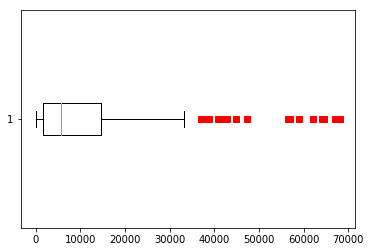

Summe: 2.924.068
Mean:     10.518


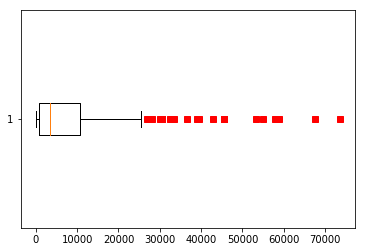

Summe: 2.311.040
Mean:      8.313


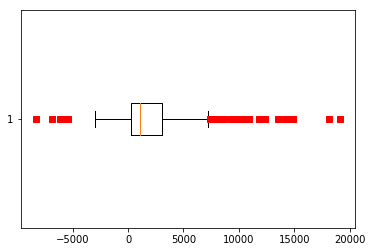

Summe:   613.028
Mean:      2.205


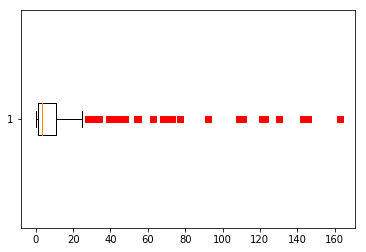

Summe:     3.631
Mean:         13


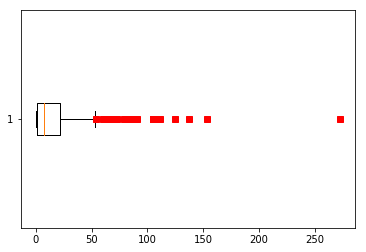

Summe:     5.123
Mean:         18


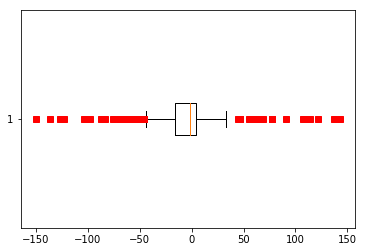

Summe:    -1.492
Mean:         -5


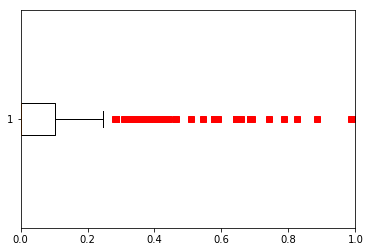

Mean:  22%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:        35 ┬        +5 (+17%)
2017:        30 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         8 ┬        +3 (+60%)
2017:         5 ┘      


2018:    58.990 ┬    +1.073 ( +2%)
2017:    57.917 ┘      


2018:         4 ┬        -1 (-20%)
2017:         5 ┘      


Wikipedia-Artikel: Serlo
Views 2018:      2.861 ┬        -6 ( -0%)
Views 2017:      2.867 ┘      

MFNF / Wikipedia – 2018: 2062%
MFNF / Wikipedia – 2017: 2020%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

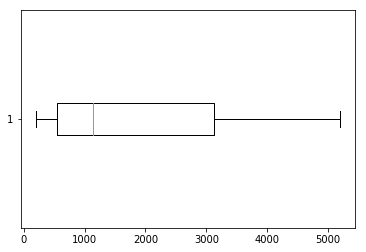

Summe:    10.226
Mean:      2.045


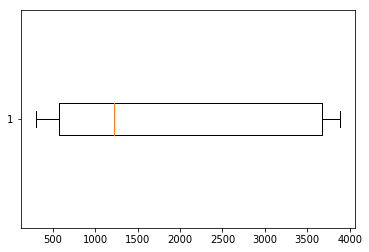

Summe:     9.664
Mean:      1.932


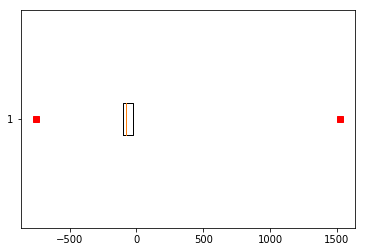

Summe:       562
Mean:        112


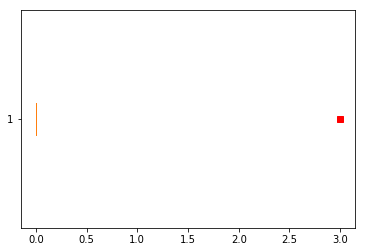

Summe:         3
Mean:          0


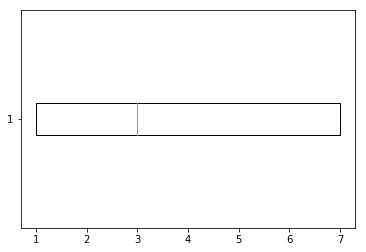

Summe:        19
Mean:          3


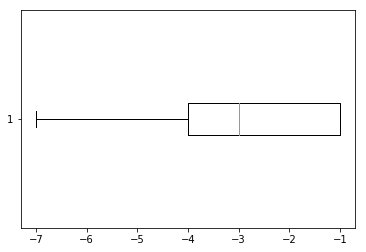

Summe:       -16
Mean:         -3


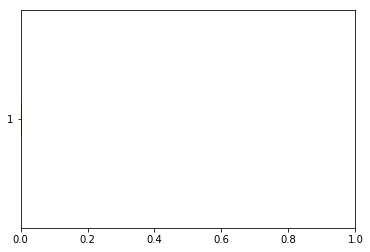

Mean:   0%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         0 ┬        +0        
2017:         0 ┘      


2018:     3.134 ┬      -753 (-19%)
2017:     3.887 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.200 ┬    +1.525 (+41%)
2017:     3.675 ┘      


2018:         0 ┬        -7 (-100%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       550 ┬       -26 ( -5%)
2017:       576 ┘      


2018:         3 ┬        -4 (-57%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.145 ┬       -80 ( -7%)
2017:     1.225 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       197 ┬      -104 (-35%)
2017:       301 ┘      


2018:         0 ┬        -3 (-100%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

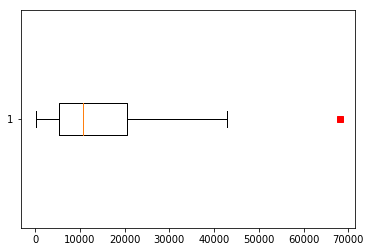

Summe:   902.822
Mean:     15.047


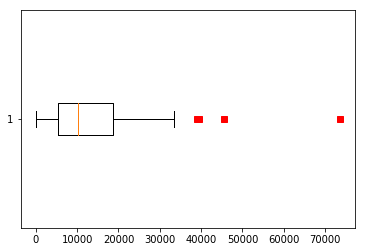

Summe:   862.856
Mean:     14.380


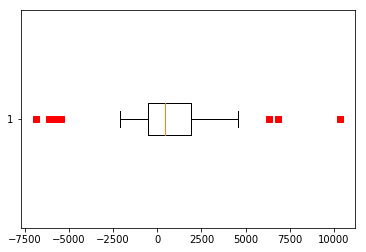

Summe:    39.966
Mean:        666


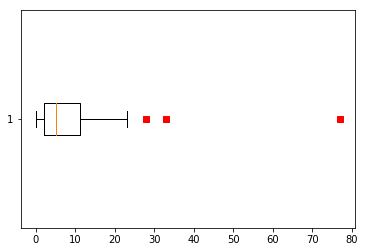

Summe:       504
Mean:          8


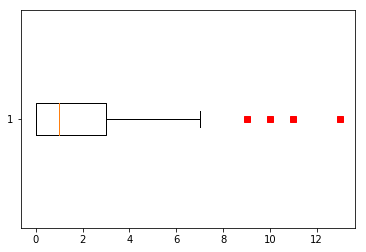

Summe:       136
Mean:          2


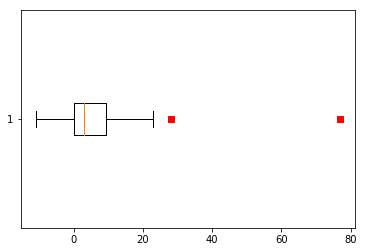

Summe:       368
Mean:          6


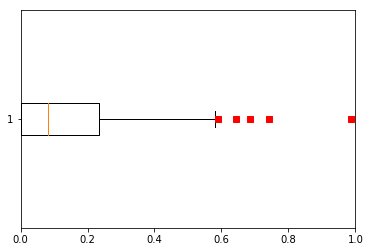

Mean:  26%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:         3 ┬        +2 (+200%)
2017:         1 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         1 ┬        +1        
2017:         0 ┘      


2018:    38.722 ┬    -6.876 (-15%)
2017:    45.598 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


Wikipedia-Artikel: Grundlagen der Mathematik
Views 2018:      6.540 ┬      -442 ( -6%)
Views 2017:      6.982 ┘      

MFNF / Wikipedia – 2018: 592%
MFNF / Wikipedia – 2017: 653%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.635 ┬      +309 ( +6%)
2017:     5.326 ┘      


2018:         7 ┬        +4 (+133%)
2017:         3 ┘      


Wikipedia-Artikel: Mathematik
Views 2018:    192.709 ┬   -23.364 (-11%)
Views 2017:    216.073 ┘      

MFNF / Wikipedia – 2018:   3%
MFNF / Wikipedia – 2017:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.806 ┬    -1.828 (-14%)
2017:    12.634 ┘      


2018:         5 ┬        +1 (+25%)
2017:         4 ┘      


Wikipedia-Artikel: Aussagenlogik
Views 2018:    107.123 ┬    -7.626 ( -7%)
Views 2017:    114.749 ┘      

MFNF / Wikipedia – 2018:  10%
MFNF / Wikipedia – 2017:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    16.837 ┬    -1.486 ( -8%)
2017:    18.323 ┘      


2018:         4 ┬        +1 (+33%)
2017:         3 ┘      


Wikipedia-Artikel: Junktor
Views 2018:     26.167 ┬      +207 ( +1%)
Views 2017:     25.960 ┘      

MFNF / Wikipedia – 2018:  64%
MFNF / Wikipedia – 2017:  71%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.803 ┬    -1.818 (-14%)
2017:    12.621 ┘      


2018:        10 ┬       +10        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    18.107 ┬    +2.368 (+15%)
2017:    15.739 ┘      


2018:        12 ┬       +12        
2017:         0 ┘      


Wikipedia-Artikel: Wahrheitstabelle
Views 2018:     57.386 ┬    -1.705 ( -3%)
Views 2017:     59.091 ┘      

MFNF / Wikipedia – 2018:  32%
MFNF / Wikipedia – 2017:  27%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    11.948 ┬    +1.109 (+10%)
2017:    10.839 ┘      


2018:        18 ┬       +17 (+1700%)
2017:         1 ┘      


Wikipedia-Artikel: Tautologie (Logik)
Views 2018:     90.678 ┬    +1.717 ( +2%)
Views 2017:     88.961 ┘      

MFNF / Wikipedia – 2018:  13%
MFNF / Wikipedia – 2017:  12%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    27.349 ┬    +2.082 ( +8%)
2017:    25.267 ┘      


2018:        18 ┬       +16 (+800%)
2017:         2 ┘      


Wikipedia-Artikel: Quantor
Views 2018:     47.276 ┬    -1.725 ( -4%)
Views 2017:     49.001 ┘      

MFNF / Wikipedia – 2018:  58%
MFNF / Wikipedia – 2017:  52%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.382 ┬      +338 (+11%)
2017:     3.044 ┘      


2018:        13 ┬       +12 (+1200%)
2017:         1 ┘      


Wikipedia-Artikel: Aussageform
Views 2018:      3.422 ┬      -391 (-10%)
Views 2017:      3.813 ┘      

MFNF / Wikipedia – 2018:  99%
MFNF / Wikipedia – 2017:  80%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       229 ┬      +229        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.116 ┬    +1.346 (+23%)
2017:     5.770 ┘      


2018:        11 ┬        +8 (+267%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    42.836 ┬    +3.763 (+10%)
2017:    39.073 ┘      


2018:         3 ┬        -4 (-57%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       140 ┬      +140        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.269 ┬   +10.346 (+116%)
2017:     8.923 ┘      


2018:         8 ┬        +8        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.776 ┬      +552 (+17%)
2017:     3.224 ┘      


2018:         2 ┬       -11 (-85%)
2017:        13 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.354 ┬    -1.536 (-16%)
2017:     9.890 ┘      


2018:         3 ┬        +3        
2017:         0 ┘      


Wikipedia-Artikel: Beweis (Mathematik)
Views 2018:     36.692 ┬      -766 ( -2%)
Views 2017:     37.458 ┘      

MFNF / Wikipedia – 2018:  23%
MFNF / Wikipedia – 2017:  26%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    23.319 ┬    -2.130 ( -8%)
2017:    25.449 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


Wikipedia-Artikel: Reductio ad absurdum
Views 2018:     31.435 ┬      +194 ( +1%)
Views 2017:     31.241 ┘      

MFNF / Wikipedia – 2018:  74%
MFNF / Wikipedia – 2017:  81%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.083 ┬    -1.809 (-18%)
2017:     9.892 ┘      


2018:         2 ┬        +0 ( +0%)
2017:         2 ┘      


Wikipedia-Artikel: Kontraposition
Views 2018:     13.698 ┬      +308 ( +2%)
Views 2017:     13.390 ┘      

MFNF / Wikipedia – 2018:  59%
MFNF / Wikipedia – 2017:  74%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.556 ┬      -495 ( -7%)
2017:     7.051 ┘      


2018:         6 ┬        +5 (+500%)
2017:         1 ┘      


Wikipedia-Artikel: Notwendige und hinreichende Bedingung
Views 2018:     84.083 ┬      +962 ( +1%)
Views 2017:     83.121 ┘      

MFNF / Wikipedia – 2018:   8%
MFNF / Wikipedia – 2017:   8%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    68.188 ┬    -5.440 ( -7%)
2017:    73.628 ┘      


2018:         2 ┬        +0 ( +0%)
2017:         2 ┘      


Wikipedia-Artikel: Vollständige Induktion
Views 2018:     99.586 ┬   -20.803 (-17%)
Views 2017:    120.389 ┘      

MFNF / Wikipedia – 2018:  68%
MFNF / Wikipedia – 2017:  61%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    37.122 ┬    +3.736 (+11%)
2017:    33.386 ┘      


2018:         2 ┬        -8 (-80%)
2017:        10 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     9.978 ┬    -1.398 (-12%)
2017:    11.376 ┘      


2018:         8 ┬        +4 (+100%)
2017:         4 ┘      


Wikipedia-Artikel: Mengenlehre
Views 2018:    141.353 ┬    -8.399 ( -6%)
Views 2017:    149.752 ┘      

MFNF / Wikipedia – 2018:   7%
MFNF / Wikipedia – 2017:   8%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    20.313 ┬    +6.310 (+45%)
2017:    14.003 ┘      


2018:        13 ┬       +13        
2017:         0 ┘      


Wikipedia-Artikel: Menge (Mathematik)
Views 2018:    120.247 ┬    -8.162 ( -6%)
Views 2017:    128.409 ┘      

MFNF / Wikipedia – 2018:  17%
MFNF / Wikipedia – 2017:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.587 ┬      -265 ( -5%)
2017:     4.852 ┘      


2018:         2 ┬        +1 (+100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    27.987 ┬    +4.085 (+17%)
2017:    23.902 ┘      


2018:         8 ┬        +6 (+300%)
2017:         2 ┘      


Wikipedia-Artikel: Teilmenge
Views 2018:     77.644 ┬    -3.136 ( -4%)
Views 2017:     80.780 ┘      

MFNF / Wikipedia – 2018:  36%
MFNF / Wikipedia – 2017:  30%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.970 ┬      -363 ( -4%)
2017:     9.333 ┘      


2018:         6 ┬        +6        
2017:         0 ┘      


Wikipedia-Artikel: Potenzmenge
Views 2018:     62.959 ┬      +610 ( +1%)
Views 2017:     62.349 ┘      

MFNF / Wikipedia – 2018:  14%
MFNF / Wikipedia – 2017:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.037 ┬    +2.727 (+37%)
2017:     7.310 ┘      


2018:        12 ┬        +6 (+100%)
2017:         6 ┘      


Wikipedia-Artikel: Leere Menge
Views 2018:     42.781 ┬    -1.258 ( -3%)
Views 2017:     44.039 ┘      

MFNF / Wikipedia – 2018:  23%
MFNF / Wikipedia – 2017:  17%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    15.790 ┬      -557 ( -3%)
2017:    16.347 ┘      


2018:         4 ┬        +2 (+100%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.613 ┬    +3.021 (+31%)
2017:     9.592 ┘      


2018:        28 ┬       +28        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.313 ┬    +4.076 (+65%)
2017:     6.237 ┘      


2018:        19 ┬       +18 (+1800%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.516 ┬      +818 (+22%)
2017:     3.698 ┘      


2018:        23 ┬       +23        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       603 ┬      +603        
2017:         0 ┘      


2018:         7 ┬        +7        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.943 ┬    -1.253 (-10%)
2017:    12.196 ┘      


2018:         7 ┬        +7        
2017:         0 ┘      


Wikipedia-Artikel: Disjunkt
Views 2018:     46.201 ┬    -4.679 ( -9%)
Views 2017:     50.880 ┘      

MFNF / Wikipedia – 2018:  24%
MFNF / Wikipedia – 2017:  24%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.450 ┬      +134 ( +3%)
2017:     5.316 ┘      


2018:         9 ┬        +9        
2017:         0 ┘      


Wikipedia-Artikel: Tupel
Views 2018:     64.523 ┬    +2.569 ( +4%)
Views 2017:     61.954 ┘      

MFNF / Wikipedia – 2018:   8%
MFNF / Wikipedia – 2017:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     9.609 ┬    -1.524 (-14%)
2017:    11.133 ┘      


2018:         2 ┬        +0 ( +0%)
2017:         2 ┘      


Wikipedia-Artikel: Kartesisches Produkt
Views 2018:     75.691 ┬    +1.727 ( +2%)
Views 2017:     73.964 ┘      

MFNF / Wikipedia – 2018:  13%
MFNF / Wikipedia – 2017:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.572 ┬      +418 (+19%)
2017:     2.154 ┘      


2018:         7 ┬        +7        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.905 ┬      +461 (+19%)
2017:     2.444 ┘      


2018:        22 ┬       +19 (+633%)
2017:         3 ┘      


Wikipedia-Artikel: Russellsche Antinomie
Views 2018:     28.568 ┬      +451 ( +2%)
Views 2017:     28.117 ┘      

MFNF / Wikipedia – 2018:  10%
MFNF / Wikipedia – 2017:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.362 ┬    +1.362        
2017:         0 ┘      


2018:        77 ┬       +77        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.950 ┬      +532 ( +5%)
2017:    10.418 ┘      


2018:         1 ┬        -2 (-67%)
2017:         3 ┘      


Wikipedia-Artikel: Relation (Mathematik)
Views 2018:     72.503 ┬    +1.163 ( +2%)
Views 2017:     71.340 ┘      

MFNF / Wikipedia – 2018:  15%
MFNF / Wikipedia – 2017:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     9.341 ┬    +1.854 (+25%)
2017:     7.487 ┘      


2018:         5 ┬        +0 ( +0%)
2017:         5 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.278 ┬    +4.248 (+53%)
2017:     8.030 ┘      


2018:         2 ┬        -2 (-50%)
2017:         4 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    31.298 ┬    +4.288 (+16%)
2017:    27.010 ┘      


2018:         1 ┬        -6 (-86%)
2017:         7 ┘      


Wikipedia-Artikel: Äquivalenzrelation
Views 2018:     85.772 ┬    -1.805 ( -2%)
Views 2017:     87.577 ┘      

MFNF / Wikipedia – 2018:  36%
MFNF / Wikipedia – 2017:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.535 ┬    +1.623 ( +9%)
2017:    17.912 ┘      


2018:        16 ┬       +15 (+1500%)
2017:         1 ┘      


Wikipedia-Artikel: Ordnungsrelation
Views 2018:     68.577 ┬      +178 ( +0%)
Views 2017:     68.399 ┘      

MFNF / Wikipedia – 2018:  28%
MFNF / Wikipedia – 2017:  26%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    42.086 ┬    +2.866 ( +7%)
2017:    39.220 ┘      


2018:        33 ┬       +22 (+200%)
2017:        11 ┘      


Wikipedia-Artikel: Funktion (Mathematik)
Views 2018:    171.044 ┬    +1.167 ( +1%)
Views 2017:    169.877 ┘      

MFNF / Wikipedia – 2018:  25%
MFNF / Wikipedia – 2017:  23%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.760 ┬    +1.176 (+16%)
2017:     7.584 ┘      


2018:         2 ┬        -1 (-33%)
2017:         3 ┘      


Wikipedia-Artikel: Verknüpfung (Mathematik)
Views 2018:     15.093 ┬      -321 ( -2%)
Views 2017:     15.414 ┘      

MFNF / Wikipedia – 2018:  58%
MFNF / Wikipedia – 2017:  49%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    16.505 ┬    -1.128 ( -6%)
2017:    17.633 ┘      


2018:        23 ┬       +18 (+360%)
2017:         5 ┘      


Wikipedia-Artikel: Mächtigkeit (Mathematik)
Views 2018:     58.693 ┬    +1.627 ( +3%)
Views 2017:     57.066 ┘      

MFNF / Wikipedia – 2018:  28%
MFNF / Wikipedia – 2017:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.935 ┬      -456 ( -8%)
2017:     5.391 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


Wikipedia-Artikel: Gleichung
Views 2018:     49.191 ┬    -8.272 (-14%)
Views 2017:     57.463 ┘      

MFNF / Wikipedia – 2018:  10%
MFNF / Wikipedia – 2017:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.875 ┬      -424 (-18%)
2017:     2.299 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       818 ┬       -34 ( -4%)
2017:       852 ┘      


2018:         0 ┬        -6 (-100%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    26.602 ┬    -5.779 (-18%)
2017:    32.381 ┘      


2018:         3 ┬        -2 (-40%)
2017:         5 ┘      


Wikipedia-Artikel: Summe
Views 2018:    135.864 ┬    +4.606 ( +4%)
Views 2017:    131.258 ┘      

MFNF / Wikipedia – 2018:  20%
MFNF / Wikipedia – 2017:  25%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    21.419 ┬    +1.512 ( +8%)
2017:    19.907 ┘      


2018:         3 ┬        +3        
2017:         0 ┘      


Wikipedia-Artikel: Gaußsche Summenformel
Views 2018:    171.589 ┬   -11.878 ( -6%)
Views 2017:    183.467 ┘      

MFNF / Wikipedia – 2018:  12%
MFNF / Wikipedia – 2017:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    40.826 ┬    +1.339 ( +3%)
2017:    39.487 ┘      


2018:         8 ┬        -1 (-11%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.312 ┬      +469 (+25%)
2017:     1.843 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    29.430 ┬    +4.561 (+18%)
2017:    24.869 ┘      


2018:        13 ┬       +11 (+550%)
2017:         2 ┘      


Wikipedia-Artikel: Fakultät (Mathematik)
Views 2018:    232.901 ┬    -4.516 ( -2%)
Views 2017:    237.417 ┘      

MFNF / Wikipedia – 2018:  13%
MFNF / Wikipedia – 2017:  10%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    21.026 ┬    -6.110 (-23%)
2017:    27.136 ┘      


2018:         2 ┬        +2        
2017:         0 ┘      


Wikipedia-Artikel: Binomialkoeffizient
Views 2018:    280.823 ┬   -21.534 ( -7%)
Views 2017:    302.357 ┘      

MFNF / Wikipedia – 2018:   7%
MFNF / Wikipedia – 2017:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    17.386 ┬      +691 ( +4%)
2017:    16.695 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


Wikipedia-Artikel: Binomischer Lehrsatz
Views 2018:     88.870 ┬    +3.201 ( +4%)
Views 2017:     85.669 ┘      

MFNF / Wikipedia – 2018:  20%
MFNF / Wikipedia – 2017:  19%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    37.298 ┬    +6.836 (+22%)
2017:    30.462 ┘      


2018:         5 ┬        +5        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.492 ┬      +420 ( +8%)
2017:     5.072 ┘      


2018:         3 ┬        +3        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.157 ┬      -409 ( -3%)
2017:    12.566 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


Wikipedia-Artikel: Liste mathematischer Symbole
Views 2018:    718.297 ┬    +5.442 ( +1%)
Views 2017:    712.855 ┘      

MFNF / Wikipedia – 2018:   2%
MFNF / Wikipedia – 2017:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.368 ┬      +336 (+11%)
2017:     3.032 ┘      


2018:         0 ┬        -2 (-100%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

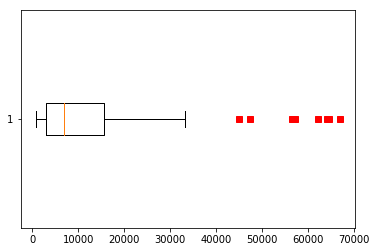

Summe: 1.578.581
Mean:     12.429


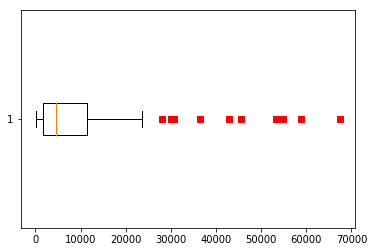

Summe: 1.173.706
Mean:      9.241


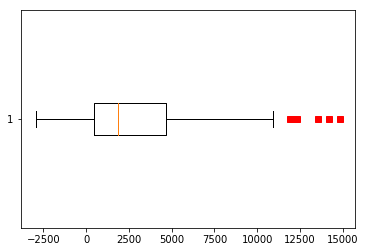

Summe:   404.875
Mean:      3.187


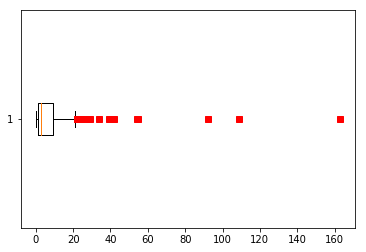

Summe:     1.231
Mean:          9


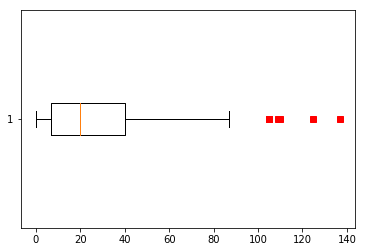

Summe:     3.600
Mean:         28


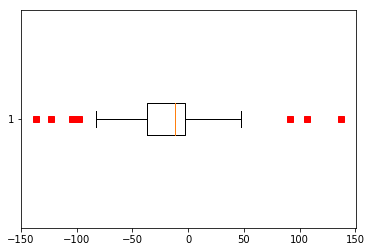

Summe:    -2.369
Mean:        -18


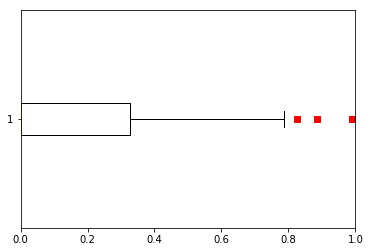

Mean:  20%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:        15 ┬       -11 (-42%)
2017:        26 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         3 ┬        -1 (-25%)
2017:         4 ┘      


2018:    64.570 ┬    -2.942 ( -4%)
2017:    67.512 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


Wikipedia-Artikel: Analysis
Views 2018:     82.114 ┬    +3.779 ( +5%)
Views 2017:     78.335 ┘      

MFNF / Wikipedia – 2018:  79%
MFNF / Wikipedia – 2017:  86%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.788 ┬      -566 ( -7%)
2017:     8.354 ┘      


2018:         2 ┬        -4 (-67%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.547 ┬      -182 ( -7%)
2017:     2.729 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.168 ┬    +1.836 (+34%)
2017:     5.332 ┘      


2018:         3 ┬       -18 (-86%)
2017:        21 ┘      


Wikipedia-Artikel: Reelle Zahl
Views 2018:    245.280 ┬   -10.047 ( -4%)
Views 2017:    255.327 ┘      

MFNF / Wikipedia – 2018:   3%
MFNF / Wikipedia – 2017:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.700 ┬      -223 ( -8%)
2017:     2.923 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


Wikipedia-Artikel: Zahlengerade
Views 2018:      8.080 ┬      -675 ( -8%)
Views 2017:      8.755 ┘      

MFNF / Wikipedia – 2018:  33%
MFNF / Wikipedia – 2017:  33%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    16.909 ┬      -359 ( -2%)
2017:    17.268 ┘      


2018:         2 ┬       -10 (-83%)
2017:        12 ┘      


Wikipedia-Artikel: Körper (Algebra)
Views 2018:     84.774 ┬    +1.809 ( +2%)
Views 2017:     82.965 ┘      

MFNF / Wikipedia – 2018:  20%
MFNF / Wikipedia – 2017:  21%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.077 ┬    +2.221 (+19%)
2017:    11.856 ┘      


2018:        29 ┬       +13 (+81%)
2017:        16 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.025 ┬    +1.595 (+66%)
2017:     2.430 ┘      


2018:         6 ┬       -29 (-83%)
2017:        35 ┘      


Wikipedia-Artikel: Potenz (Mathematik)
Views 2018:    203.505 ┬    -8.728 ( -4%)
Views 2017:    212.233 ┘      

MFNF / Wikipedia – 2018:   2%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.418 ┬      +184 ( +3%)
2017:     6.234 ┘      


2018:         1 ┬        -6 (-86%)
2017:         7 ┘      


Wikipedia-Artikel: Geordneter Körper
Views 2018:     11.089 ┬      +201 ( +2%)
Views 2017:     10.888 ┘      

MFNF / Wikipedia – 2018:  58%
MFNF / Wikipedia – 2017:  57%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.350 ┬      +768 (+17%)
2017:     4.582 ┘      


2018:         0 ┬       -39 (-100%)
2017:        39 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    22.991 ┬    +3.918 (+21%)
2017:    19.073 ┘      


2018:         8 ┬       -23 (-74%)
2017:        31 ┘      


Wikipedia-Artikel: Betragsfunktion
Views 2018:     74.696 ┬      -832 ( -1%)
Views 2017:     75.528 ┘      

MFNF / Wikipedia – 2018:  31%
MFNF / Wikipedia – 2017:  25%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.609 ┬    -1.220 (-10%)
2017:    11.829 ┘      


2018:         0 ┬        -5 (-100%)
2017:         5 ┘      


Wikipedia-Artikel: Intervall (Mathematik)
Views 2018:     93.165 ┬    -7.722 ( -8%)
Views 2017:    100.887 ┘      

MFNF / Wikipedia – 2018:  11%
MFNF / Wikipedia – 2017:  12%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.700 ┬    -1.231 (-25%)
2017:     4.931 ┘      


2018:         0 ┬        -9 (-100%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.988 ┬      +499 ( +8%)
2017:     6.489 ┘      


2018:         1 ┬        -4 (-80%)
2017:         5 ┘      


Wikipedia-Artikel: Archimedisches Axiom
Views 2018:     16.775 ┬    -1.287 ( -7%)
Views 2017:     18.062 ┘      

MFNF / Wikipedia – 2018:  42%
MFNF / Wikipedia – 2017:  36%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.517 ┬       +83 ( +1%)
2017:    14.434 ┘      


2018:         0 ┬       -13 (-100%)
2017:        13 ┘      


Wikipedia-Artikel: Bernoullische Ungleichung
Views 2018:     32.975 ┬    -3.100 ( -9%)
Views 2017:     36.075 ┘      

MFNF / Wikipedia – 2018:  44%
MFNF / Wikipedia – 2017:  40%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.488 ┬    -1.797 (-25%)
2017:     7.285 ┘      


2018:         4 ┬        +2 (+100%)
2017:         2 ┘      


Wikipedia-Artikel: Intervallschachtelung
Views 2018:     12.931 ┬    -2.163 (-14%)
Views 2017:     15.094 ┘      

MFNF / Wikipedia – 2018:  42%
MFNF / Wikipedia – 2017:  48%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.544 ┬    +2.071 (+141%)
2017:     1.473 ┘      


2018:        55 ┬       +47 (+588%)
2017:         8 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.575 ┬    +1.932 (+300%)
2017:       643 ┘      


2018:       109 ┬      +107 (+5350%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.466 ┬    +4.765 (+280%)
2017:     1.701 ┘      


2018:       163 ┬      +137 (+527%)
2017:        26 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.692 ┬    +5.514 (+3098%)
2017:       178 ┘      


2018:        92 ┬       +91 (+9100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.341 ┬    +4.126 (+128%)
2017:     3.215 ┘      


2018:         1 ┬      -136 (-99%)
2017:       137 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.235 ┬    +1.606 (+255%)
2017:       629 ┘      


2018:        39 ┬       +33 (+550%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    23.203 ┬    +1.135 ( +5%)
2017:    22.068 ┘      


2018:         0 ┬       -34 (-100%)
2017:        34 ┘      


Wikipedia-Artikel: Infimum und Supremum
Views 2018:     65.823 ┬    +3.310 ( +5%)
Views 2017:     62.513 ┘      

MFNF / Wikipedia – 2018:  35%
MFNF / Wikipedia – 2017:  35%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.135 ┬      +430 (+16%)
2017:     2.705 ┘      


2018:         1 ┬        -7 (-88%)
2017:         8 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    28.287 ┬      +242 ( +1%)
2017:    28.045 ┘      


2018:        19 ┬        -7 (-27%)
2017:        26 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.040 ┬    +3.450 (+33%)
2017:    10.590 ┘      


2018:         5 ┬       -39 (-89%)
2017:        44 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.824 ┬    +1.595 (+49%)
2017:     3.229 ┘      


2018:         0 ┬       -18 (-100%)
2017:        18 ┘      


Wikipedia-Artikel: Wurzel (Mathematik)
Views 2018:    125.737 ┬   -21.648 (-15%)
Views 2017:    147.385 ┘      

MFNF / Wikipedia – 2018:   4%
MFNF / Wikipedia – 2017:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.198 ┬       -55 ( -4%)
2017:     1.253 ┘      


2018:         0 ┬        -8 (-100%)
2017:         8 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.168 ┬      +874 (+68%)
2017:     1.294 ┘      


2018:         4 ┬        +0 ( +0%)
2017:         4 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.808 ┬      +717 (+66%)
2017:     1.091 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       816 ┬      +146 (+22%)
2017:       670 ┘      


2018:         3 ┬        +1 (+50%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.994 ┬    -1.131 ( -9%)
2017:    12.125 ┘      


2018:         3 ┬       -58 (-95%)
2017:        61 ┘      


Wikipedia-Artikel: Folge (Mathematik)
Views 2018:     67.360 ┬    -3.691 ( -5%)
Views 2017:     71.051 ┘      

MFNF / Wikipedia – 2018:  16%
MFNF / Wikipedia – 2017:  17%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    30.439 ┬      -199 ( -1%)
2017:    30.638 ┘      


2018:         2 ┬       -49 (-96%)
2017:        51 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    15.534 ┬    +2.362 (+18%)
2017:    13.172 ┘      


2018:        19 ┬       -49 (-72%)
2017:        68 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.228 ┬      +204 (+10%)
2017:     2.024 ┘      


2018:         2 ┬        -5 (-71%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    62.127 ┬    +3.222 ( +5%)
2017:    58.905 ┘      


2018:         7 ┬       -76 (-92%)
2017:        83 ┘      


Wikipedia-Artikel: Grenzwert (Folge)
Views 2018:     94.573 ┬   -15.832 (-14%)
Views 2017:    110.405 ┘      

MFNF / Wikipedia – 2018:  66%
MFNF / Wikipedia – 2017:  53%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    64.112 ┬   +10.796 (+20%)
2017:    53.316 ┘      


2018:        14 ┬       -27 (-66%)
2017:        41 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    56.396 ┬   +10.931 (+24%)
2017:    45.465 ┘      


2018:         2 ┬       -44 (-96%)
2017:        46 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.592 ┬      +601 (+10%)
2017:     5.991 ┘      


2018:         1 ┬       -20 (-95%)
2017:        21 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    47.329 ┬   +10.825 (+30%)
2017:    36.504 ┘      


2018:         7 ┬       -61 (-90%)
2017:        68 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.724 ┬    +1.750 (+16%)
2017:    10.974 ┘      


2018:         4 ┬       -37 (-90%)
2017:        41 ┘      


Wikipedia-Artikel: Einschnürungssatz
Views 2018:      9.642 ┬    -1.395 (-13%)
Views 2017:     11.037 ┘      

MFNF / Wikipedia – 2018: 132%
MFNF / Wikipedia – 2017:  99%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.369 ┬    +4.066 (+49%)
2017:     8.303 ┘      


2018:         2 ┬        +0 ( +0%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    26.085 ┬    +2.449 (+10%)
2017:    23.636 ┘      


2018:        10 ┬        -9 (-47%)
2017:        19 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    18.513 ┬   +10.268 (+125%)
2017:     8.245 ┘      


2018:         7 ┬        -6 (-46%)
2017:        13 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.073 ┬      +418 ( +4%)
2017:    11.655 ┘      


2018:         9 ┬       -13 (-59%)
2017:        22 ┘      


Wikipedia-Artikel: Teilfolge
Views 2018:      8.616 ┬        +0 ( +0%)
Views 2017:      8.616 ┘      

MFNF / Wikipedia – 2018: 140%
MFNF / Wikipedia – 2017: 135%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.339 ┬    -1.616 ( -8%)
2017:    20.955 ┘      


2018:         0 ┬       -42 (-100%)
2017:        42 ┘      


Wikipedia-Artikel: Häufungspunkt
Views 2018:     28.279 ┬      -830 ( -3%)
Views 2017:     29.109 ┘      

MFNF / Wikipedia – 2018:  68%
MFNF / Wikipedia – 2017:  72%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.606 ┬      -299 ( -4%)
2017:     6.905 ┘      


2018:         1 ┬        -9 (-90%)
2017:        10 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.994 ┬      +575 ( +7%)
2017:     8.419 ┘      


2018:         7 ┬       -12 (-63%)
2017:        19 ┘      


Wikipedia-Artikel: Satz von Bolzano-Weierstraß
Views 2018:     24.430 ┬      +283 ( +1%)
Views 2017:     24.147 ┘      

MFNF / Wikipedia – 2018:  37%
MFNF / Wikipedia – 2017:  35%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.398 ┬    +3.168 (+44%)
2017:     7.230 ┘      


2018:         5 ┬       -11 (-69%)
2017:        16 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.944 ┬      +757 (+64%)
2017:     1.187 ┘      


2018:         3 ┬        -1 (-25%)
2017:         4 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    24.039 ┬    +2.562 (+12%)
2017:    21.477 ┘      


2018:        14 ┬       -56 (-80%)
2017:        70 ┘      


Wikipedia-Artikel: Limes superior und Limes inferior
Views 2018:     34.843 ┬      -156 ( -0%)
Views 2017:     34.999 ┘      

MFNF / Wikipedia – 2018:  69%
MFNF / Wikipedia – 2017:  61%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    25.434 ┬    +2.857 (+13%)
2017:    22.577 ┘      


2018:         7 ┬       -15 (-68%)
2017:        22 ┘      


Wikipedia-Artikel: Cauchy-Folge
Views 2018:     39.495 ┬    +2.077 ( +6%)
Views 2017:     37.418 ┘      

MFNF / Wikipedia – 2018:  64%
MFNF / Wikipedia – 2017:  60%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.312 ┬    +1.331 (+67%)
2017:     1.981 ┘      


2018:        11 ┬        -2 (-15%)
2017:        13 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    25.564 ┬    +9.329 (+57%)
2017:    16.235 ┘      


2018:        19 ┬       -41 (-68%)
2017:        60 ┘      


Wikipedia-Artikel: Reihe (Mathematik)
Views 2018:     76.480 ┬    -7.953 ( -9%)
Views 2017:     84.433 ┘      

MFNF / Wikipedia – 2018:  33%
MFNF / Wikipedia – 2017:  19%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    13.282 ┬    +4.548 (+52%)
2017:     8.734 ┘      


2018:        21 ┬        -3 (-12%)
2017:        24 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    15.727 ┬    +4.549 (+41%)
2017:    11.178 ┘      


2018:        25 ┬        -5 (-17%)
2017:        30 ┘      


Wikipedia-Artikel: Teleskopsumme
Views 2018:     17.747 ┬      +815 ( +5%)
Views 2017:     16.932 ┘      

MFNF / Wikipedia – 2018:  89%
MFNF / Wikipedia – 2017:  66%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    66.952 ┬   +12.034 (+22%)
2017:    54.918 ┘      


2018:        22 ┬        -9 (-29%)
2017:        31 ┘      


Wikipedia-Artikel: Geometrische Reihe
Views 2018:    234.314 ┬    -3.069 ( -1%)
Views 2017:    237.383 ┘      

MFNF / Wikipedia – 2018:  29%
MFNF / Wikipedia – 2017:  23%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    27.712 ┬   +10.058 (+57%)
2017:    17.654 ┘      


2018:        34 ┬       +13 (+62%)
2017:        21 ┘      


Wikipedia-Artikel: Harmonische Reihe
Views 2018:     86.718 ┬    +5.291 ( +6%)
Views 2017:     81.427 ┘      

MFNF / Wikipedia – 2018:  32%
MFNF / Wikipedia – 2017:  22%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    13.486 ┬    +8.650 (+179%)
2017:     4.836 ┘      


2018:         0 ┬        -6 (-100%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    18.100 ┬    +6.210 (+52%)
2017:    11.890 ┘      


2018:         3 ┬       -17 (-85%)
2017:        20 ┘      


Wikipedia-Artikel: Absolut konvergente Reihe
Views 2018:     18.262 ┬    -1.537 ( -8%)
Views 2017:     19.799 ┘      

MFNF / Wikipedia – 2018:  99%
MFNF / Wikipedia – 2017:  60%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.145 ┬    +2.796 (+64%)
2017:     4.349 ┘      


2018:        19 ┬       -29 (-60%)
2017:        48 ┘      


Wikipedia-Artikel: Umordnung von Reihen
Views 2018:      3.302 ┬      -457 (-12%)
Views 2017:      3.759 ┘      

MFNF / Wikipedia – 2018: 216%
MFNF / Wikipedia – 2017: 116%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.890 ┬    +1.681 (+76%)
2017:     2.209 ┘      


2018:        11 ┬        +1 (+10%)
2017:        10 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    57.058 ┬   +14.205 (+33%)
2017:    42.853 ┘      


2018:        11 ┬        -4 (-27%)
2017:        15 ┘      


Wikipedia-Artikel: Konvergenzkriterium
Views 2018:     31.886 ┬    -3.686 (-10%)
Views 2017:     35.572 ┘      

MFNF / Wikipedia – 2018: 179%
MFNF / Wikipedia – 2017: 120%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.133 ┬    +1.878 (+18%)
2017:    10.255 ┘      


2018:         2 ┬        -4 (-67%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.282 ┬    +1.877 (+55%)
2017:     3.405 ┘      


2018:         2 ┬        -3 (-60%)
2017:         5 ┘      


Wikipedia-Artikel: Nullfolgenkriterium
Views 2018:     13.101 ┬      +162 ( +1%)
Views 2017:     12.939 ┘      

MFNF / Wikipedia – 2018:  40%
MFNF / Wikipedia – 2017:  26%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.602 ┬    +1.604 (+32%)
2017:     4.998 ┘      


2018:         0 ┬        -3 (-100%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    25.936 ┬    +8.111 (+46%)
2017:    17.825 ┘      


2018:         5 ┬       -21 (-81%)
2017:        26 ┘      


Wikipedia-Artikel: Majorantenkriterium
Views 2018:     23.296 ┬    -2.586 (-10%)
Views 2017:     25.882 ┘      

MFNF / Wikipedia – 2018: 111%
MFNF / Wikipedia – 2017:  69%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    13.577 ┬    +3.049 (+29%)
2017:    10.528 ┘      


2018:         4 ┬       -16 (-80%)
2017:        20 ┘      


Wikipedia-Artikel: Wurzelkriterium
Views 2018:     29.387 ┬      +252 ( +1%)
Views 2017:     29.135 ┘      

MFNF / Wikipedia – 2018:  46%
MFNF / Wikipedia – 2017:  36%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.067 ┬    +5.334 (+39%)
2017:    13.733 ┘      


2018:        28 ┬        -3 (-10%)
2017:        31 ┘      


Wikipedia-Artikel: Quotientenkriterium
Views 2018:     43.329 ┬    -1.708 ( -4%)
Views 2017:     45.037 ┘      

MFNF / Wikipedia – 2018:  44%
MFNF / Wikipedia – 2017:  30%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    18.955 ┬    +6.880 (+57%)
2017:    12.075 ┘      


2018:         4 ┬       -26 (-87%)
2017:        30 ┘      


Wikipedia-Artikel: Leibniz-Kriterium
Views 2018:     37.337 ┬    -1.007 ( -3%)
Views 2017:     38.344 ┘      

MFNF / Wikipedia – 2018:  51%
MFNF / Wikipedia – 2017:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.288 ┬      +784 (+17%)
2017:     4.504 ┘      


2018:         3 ┬        -4 (-57%)
2017:         7 ┘      


Wikipedia-Artikel: Cauchysches Verdichtungskriterium
Views 2018:      9.694 ┬    -1.429 (-13%)
Views 2017:     11.123 ┘      

MFNF / Wikipedia – 2018:  55%
MFNF / Wikipedia – 2017:  40%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    15.220 ┬   +10.495 (+222%)
2017:     4.725 ┘      


2018:         1 ┬       -10 (-91%)
2017:        11 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    17.602 ┬   +10.949 (+165%)
2017:     6.653 ┘      


2018:        22 ┬        +8 (+57%)
2017:        14 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.222 ┬    +2.114 (+68%)
2017:     3.108 ┘      


2018:         0 ┬       -49 (-100%)
2017:        49 ┘      


Wikipedia-Artikel: Exponentialfunktion
Views 2018:    320.563 ┬   -19.315 ( -6%)
Views 2017:    339.878 ┘      

MFNF / Wikipedia – 2018:   2%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.319 ┬    +4.465 (+241%)
2017:     1.854 ┘      


2018:         0 ┬       -22 (-100%)
2017:        22 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.662 ┬      +903 (+119%)
2017:       759 ┘      


2018:         3 ┬        -8 (-73%)
2017:        11 ┘      


Wikipedia-Artikel: Logarithmus
Views 2018:    452.356 ┬   -63.472 (-12%)
Views 2017:    515.828 ┘      

MFNF / Wikipedia – 2018:   0%
MFNF / Wikipedia – 2017:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.192 ┬      +492 (+70%)
2017:       700 ┘      


2018:         0 ┬        -2 (-100%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       832 ┬      +319 (+62%)
2017:       513 ┘      


2018:         0 ┬       -14 (-100%)
2017:        14 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       761 ┬      +296 (+64%)
2017:       465 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.838 ┬    +4.387 (+179%)
2017:     2.451 ┘      


2018:         1 ┬       -53 (-98%)
2017:        54 ┘      


Wikipedia-Artikel: Sinus und Kosinus
Views 2018:    648.019 ┬   -57.320 ( -8%)
Views 2017:    705.339 ┘      

MFNF / Wikipedia – 2018:   1%
MFNF / Wikipedia – 2017:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.565 ┬    +1.639 (+177%)
2017:       926 ┘      


2018:         0 ┬       -46 (-100%)
2017:        46 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.195 ┬    +5.284 (+277%)
2017:     1.911 ┘      


2018:         1 ┬       -25 (-96%)
2017:        26 ┘      


Wikipedia-Artikel: Arkussinus und Arkuskosinus
Views 2018:    122.689 ┬    -8.057 ( -6%)
Views 2017:    130.746 ┘      

MFNF / Wikipedia – 2018:   6%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       782 ┬      +360 (+85%)
2017:       422 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


Wikipedia-Artikel: Tangens und Kotangens
Views 2018:    323.059 ┬   -17.997 ( -5%)
Views 2017:    341.056 ┘      

MFNF / Wikipedia – 2018:   0%
MFNF / Wikipedia – 2017:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.195 ┬    +5.284 (+277%)
2017:     1.911 ┘      


2018:         1 ┬        -6 (-86%)
2017:         7 ┘      


Wikipedia-Artikel: Arkustangens und Arkuskotangens
Views 2018:    138.846 ┬   -14.940 (-10%)
Views 2017:    153.786 ┘      

MFNF / Wikipedia – 2018:   5%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.331 ┬      +626 (+89%)
2017:       705 ┘      


2018:         8 ┬        +4 (+100%)
2017:         4 ┘      


Wikipedia-Artikel: Sinus hyperbolicus und Kosinus hyperbolicus
Views 2018:    137.285 ┬    -3.353 ( -2%)
Views 2017:    140.638 ┘      

MFNF / Wikipedia – 2018:   1%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       879 ┬      +346 (+65%)
2017:       533 ┘      


2018:         1 ┬        -8 (-89%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    28.081 ┬    +9.346 (+50%)
2017:    18.735 ┘      


2018:         5 ┬       -68 (-93%)
2017:        73 ┘      


Wikipedia-Artikel: Stetigkeit
Views 2018:    114.252 ┬    -7.715 ( -6%)
Views 2017:    121.967 ┘      

MFNF / Wikipedia – 2018:  25%
MFNF / Wikipedia – 2017:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    44.957 ┬   +14.854 (+49%)
2017:    30.103 ┘      


2018:         9 ┬       -70 (-89%)
2017:        79 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    33.234 ┬   +11.906 (+56%)
2017:    21.328 ┘      


2018:        11 ┬       -98 (-90%)
2017:       109 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.400 ┬    +2.676 (+72%)
2017:     3.724 ┘      


2018:         1 ┬      -104 (-99%)
2017:       105 ┘      


Wikipedia-Artikel: Grenzwert (Funktion)
Views 2018:     91.493 ┬    +6.663 ( +8%)
Views 2017:     84.830 ┘      

MFNF / Wikipedia – 2018:   7%
MFNF / Wikipedia – 2017:   4%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     9.128 ┬    +2.482 (+37%)
2017:     6.646 ┘      


2018:         4 ┬       -31 (-89%)
2017:        35 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    26.812 ┬   +12.353 (+85%)
2017:    14.459 ┘      


2018:         4 ┬       -83 (-95%)
2017:        87 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.730 ┬    +1.870 (+101%)
2017:     1.860 ┘      


2018:         1 ┬       -36 (-97%)
2017:        37 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.899 ┬    +4.876 (+49%)
2017:    10.023 ┘      


2018:         7 ┬       -40 (-85%)
2017:        47 ┘      


Wikipedia-Artikel: Zwischenwertsatz
Views 2018:     31.998 ┬      +408 ( +1%)
Views 2017:     31.590 ┘      

MFNF / Wikipedia – 2018:  47%
MFNF / Wikipedia – 2017:  32%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    11.782 ┬    +3.883 (+49%)
2017:     7.899 ┘      


2018:         5 ┬       -44 (-90%)
2017:        49 ┘      


Wikipedia-Artikel: Satz vom Minimum und Maximum
Views 2018:     14.272 ┬    +1.794 (+14%)
Views 2017:     12.478 ┘      

MFNF / Wikipedia – 2018:  83%
MFNF / Wikipedia – 2017:  63%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.130 ┬    +2.299 (+60%)
2017:     3.831 ┘      


2018:         3 ┬       -23 (-88%)
2017:        26 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    16.991 ┬    +7.092 (+72%)
2017:     9.899 ┘      


2018:         5 ┬       -66 (-93%)
2017:        71 ┘      


Wikipedia-Artikel: Gleichmäßige Stetigkeit
Views 2018:     26.356 ┬      -233 ( -1%)
Views 2017:     26.589 ┘      

MFNF / Wikipedia – 2018:  64%
MFNF / Wikipedia – 2017:  37%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.813 ┬   +13.574 (+218%)
2017:     6.239 ┘      


2018:        54 ┬       +19 (+54%)
2017:        35 ┘      


Wikipedia-Artikel: Lipschitz-Stetigkeit
Views 2018:     51.361 ┬      +326 ( +1%)
Views 2017:     51.035 ┘      

MFNF / Wikipedia – 2018:  39%
MFNF / Wikipedia – 2017:  12%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.582 ┬    +1.369 (+43%)
2017:     3.213 ┘      


2018:         1 ┬       -15 (-94%)
2017:        16 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.655 ┬    +7.226 (+97%)
2017:     7.429 ┘      


2018:         2 ┬      -123 (-98%)
2017:       125 ┘      


Wikipedia-Artikel: Differentialrechnung
Views 2018:    210.993 ┬   -16.781 ( -7%)
Views 2017:    227.774 ┘      

MFNF / Wikipedia – 2018:   7%
MFNF / Wikipedia – 2017:   3%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.596 ┬      +415 (+19%)
2017:     2.181 ┘      


2018:         1 ┬       -35 (-97%)
2017:        36 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.182 ┬      +888 (+302%)
2017:       294 ┘      


2018:         1 ┬        -1 (-50%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.025 ┬    +1.870 (+59%)
2017:     3.155 ┘      


2018:         2 ┬       -20 (-91%)
2017:        22 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.519 ┬      +152 (+11%)
2017:     1.367 ┘      


2018:         2 ┬       -15 (-88%)
2017:        17 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.728 ┬    +1.988 (+114%)
2017:     1.740 ┘      


2018:         9 ┬        -7 (-44%)
2017:        16 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.059 ┬    +2.064 (+52%)
2017:     3.995 ┘      


2018:         7 ┬        -5 (-42%)
2017:        12 ┘      


Wikipedia-Artikel: Satz von Rolle
Views 2018:     17.116 ┬    +2.925 (+21%)
Views 2017:     14.191 ┘      

MFNF / Wikipedia – 2018:  35%
MFNF / Wikipedia – 2017:  28%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.038 ┬    +7.981 (+72%)
2017:    11.057 ┘      


2018:         5 ┬       -41 (-89%)
2017:        46 ┘      


Wikipedia-Artikel: Mittelwertsatz der Differentialrechnung
Views 2018:     56.798 ┬      -423 ( -1%)
Views 2017:     57.221 ┘      

MFNF / Wikipedia – 2018:  34%
MFNF / Wikipedia – 2017:  19%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.875 ┬       -17 ( -1%)
2017:     1.892 ┘      


2018:         1 ┬       -19 (-95%)
2017:        20 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.686 ┬    +3.627 (+342%)
2017:     1.059 ┘      


2018:         1 ┬       -10 (-91%)
2017:        11 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     6.632 ┬    +3.425 (+107%)
2017:     3.207 ┘      


2018:         9 ┬       -29 (-76%)
2017:        38 ┘      


Wikipedia-Artikel: Extremwert
Views 2018:     55.451 ┬      -376 ( -1%)
Views 2017:     55.827 ┘      

MFNF / Wikipedia – 2018:  12%
MFNF / Wikipedia – 2017:   6%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     8.608 ┬    +5.398 (+168%)
2017:     3.210 ┘      


2018:        16 ┬        +9 (+129%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.549 ┬    +1.901 (+293%)
2017:       648 ┘      


2018:         3 ┬        -6 (-67%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.965 ┬      +308 (+19%)
2017:     1.657 ┘      


2018:         2 ┬        -1 (-33%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       998 ┬      +257 (+35%)
2017:       741 ┘      


2018:         5 ┬        +2 (+67%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       909 ┬      +251 (+38%)
2017:       658 ┘      


2018:         2 ┬        -4 (-67%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       945 ┬      +331 (+54%)
2017:       614 ┘      


2018:        14 ┬       +12 (+600%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.340 ┬    +1.173 (+37%)
2017:     3.167 ┘      


2018:         3 ┬       -20 (-87%)
2017:        23 ┘      


Wikipedia-Artikel: Integralrechnung
Views 2018:    202.605 ┬   -29.193 (-13%)
Views 2017:    231.798 ┘      

MFNF / Wikipedia – 2018:   2%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     9.696 ┬    +5.223 (+117%)
2017:     4.473 ┘      


2018:         8 ┬       -54 (-87%)
2017:        62 ┘      


Wikipedia-Artikel: Riemannsches Integral
Views 2018:     50.652 ┬    -2.599 ( -5%)
Views 2017:     53.251 ┘      

MFNF / Wikipedia – 2018:  19%
MFNF / Wikipedia – 2017:   8%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.420 ┬    +1.268 (+110%)
2017:     1.152 ┘      


2018:         0 ┬       -13 (-100%)
2017:        13 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.614 ┬      +991 (+61%)
2017:     1.623 ┘      


2018:         0 ┬       -19 (-100%)
2017:        19 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.433 ┬    +5.945 (+400%)
2017:     1.488 ┘      


2018:         0 ┬       -38 (-100%)
2017:        38 ┘      


Wikipedia-Artikel: Mittelwertsatz der Integralrechnung
Views 2018:     22.095 ┬    -2.507 (-10%)
Views 2017:     24.602 ┘      

MFNF / Wikipedia – 2018:  34%
MFNF / Wikipedia – 2017:   6%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    15.372 ┬    +8.136 (+112%)
2017:     7.236 ┘      


2018:         5 ┬      -100 (-95%)
2017:       105 ┘      


Wikipedia-Artikel: Fundamentalsatz der Analysis
Views 2018:     62.312 ┬   +23.114 (+59%)
Views 2017:     39.198 ┘      

MFNF / Wikipedia – 2018:  25%
MFNF / Wikipedia – 2017:  18%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.255 ┬    +3.072 (+73%)
2017:     4.183 ┘      


2018:        42 ┬       -68 (-62%)
2017:       110 ┘      


Wikipedia-Artikel: Integration durch Substitution
Views 2018:     73.440 ┬    -6.510 ( -8%)
Views 2017:     79.950 ┘      

MFNF / Wikipedia – 2018:  10%
MFNF / Wikipedia – 2017:   5%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.193 ┬    +2.001 (+91%)
2017:     2.192 ┘      


2018:        24 ┬       -48 (-67%)
2017:        72 ┘      


Wikipedia-Artikel: Partielle Integration
Views 2018:    184.937 ┬    -9.354 ( -5%)
Views 2017:    194.291 ┘      

MFNF / Wikipedia – 2018:   2%
MFNF / Wikipedia – 2017:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       780 ┬      +696 (+829%)
2017:        84 ┘      


2018:         2 ┬        +2        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.083 ┬      +264 (+32%)
2017:       819 ┘      


2018:         3 ┬       -49 (-94%)
2017:        52 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.778 ┬      +896 (+102%)
2017:       882 ┘      


2018:        16 ┬       -17 (-52%)
2017:        33 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

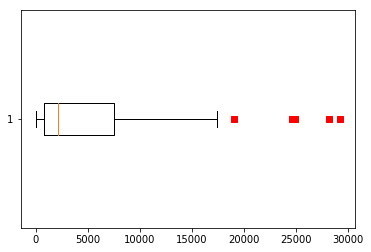

Summe:   353.716
Mean:      5.705


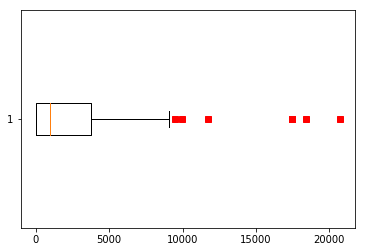

Summe:   192.884
Mean:      3.111


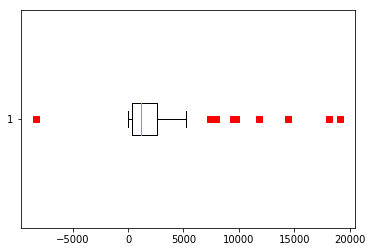

Summe:   160.832
Mean:      2.594


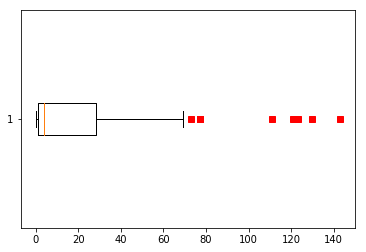

Summe:     1.583
Mean:         25


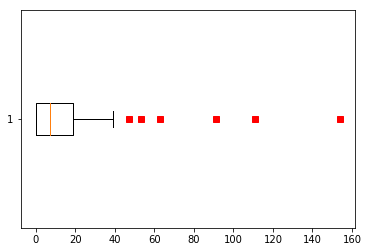

Summe:       995
Mean:         16


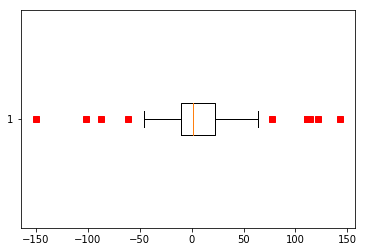

Summe:       588
Mean:          9


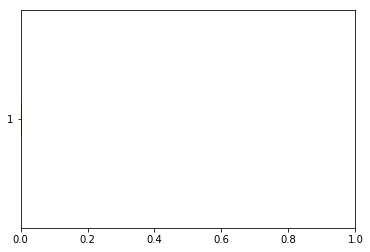

Mean:   0%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:        16 ┬        +9 (+129%)
2017:         7 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         5 ┬        +4 (+400%)
2017:         1 ┘      


2018:    28.148 ┬    +9.763 (+53%)
2017:    18.385 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    10.102 ┬    +1.851 (+22%)
2017:     8.251 ┘      


2018:       121 ┬      +111 (+1110%)
2017:        10 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       711 ┬      +711        
2017:         0 ┘      


2018:         2 ┬        +2        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.617 ┬    +1.617        
2017:         0 ┘      


2018:        18 ┬       +18        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.275 ┬    +2.080 (+1067%)
2017:       195 ┘      


2018:       143 ┬      +143        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       807 ┬      +807        
2017:         0 ┘      


2018:        24 ┬       +24        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       424 ┬      +424        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       796 ┬      +796        
2017:         0 ┘      


2018:        45 ┬       +45        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.709 ┬    +2.709        
2017:         0 ┘      


2018:       122 ┬      +122        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    17.384 ┬    +9.466 (+120%)
2017:     7.918 ┘      


2018:        73 ┬       +61 (+508%)
2017:        12 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     4.733 ┬    +2.505 (+112%)
2017:     2.228 ┘      


2018:        24 ┬       +16 (+200%)
2017:         8 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       431 ┬      +431        
2017:         0 ┘      


2018:         2 ┬        +2        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.139 ┬      +187 (+10%)
2017:     1.952 ┘      


2018:         2 ┬       -20 (-91%)
2017:        22 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.316 ┬      +308 (+31%)
2017:     1.008 ┘      


2018:         0 ┬        -7 (-100%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.668 ┬      +817 (+96%)
2017:       851 ┘      


2018:         0 ┬        -6 (-100%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.259 ┬      +352 (+39%)
2017:       907 ┘      


2018:         0 ┬        -5 (-100%)
2017:         5 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    29.222 ┬   +11.792 (+68%)
2017:    17.430 ┘      


2018:        69 ┬       +58 (+527%)
2017:        11 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.542 ┬    +2.601 (+26%)
2017:     9.941 ┘      


2018:        20 ┬       +16 (+400%)
2017:         4 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.308 ┬      +852 (+187%)
2017:       456 ┘      


2018:       111 ┬      +111        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.837 ┬    +3.082 (+26%)
2017:    11.755 ┘      


2018:        30 ┬       +15 (+100%)
2017:        15 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.714 ┬    +3.680 (+181%)
2017:     2.034 ┘      


2018:       123 ┬      +114 (+1267%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       202 ┬      +202        
2017:         0 ┘      


2018:        13 ┬       +13        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.209 ┬    +1.209        
2017:         0 ┘      


2018:        63 ┬       +63        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.456 ┬    +3.456        
2017:         0 ┘      


2018:        55 ┬       +55        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.269 ┬    +5.196 (+73%)
2017:     7.073 ┘      


2018:        68 ┬       +47 (+224%)
2017:        21 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    14.439 ┬    +4.936 (+52%)
2017:     9.503 ┘      


2018:        77 ┬       +64 (+492%)
2017:        13 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    17.012 ┬    +7.957 (+88%)
2017:     9.055 ┘      


2018:        77 ┬       +61 (+381%)
2017:        16 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    11.531 ┬    +7.409 (+180%)
2017:     4.122 ┘      


2018:        48 ┬       +29 (+153%)
2017:        19 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.098 ┬    +2.235 (+46%)
2017:     4.863 ┘      


2018:       130 ┬       +77 (+145%)
2017:        53 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.063 ┬    +1.020 (+98%)
2017:     1.043 ┘      


2018:         2 ┬       -36 (-95%)
2017:        38 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.624 ┬    +2.403 (+197%)
2017:     1.221 ┘      


2018:         1 ┬       -24 (-96%)
2017:        25 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    24.595 ┬   +19.146 (+351%)
2017:     5.449 ┘      


2018:         4 ┬      -150 (-97%)
2017:       154 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    19.073 ┬    +1.589 ( +9%)
2017:    17.484 ┘      


2018:         5 ┬        -9 (-64%)
2017:        14 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    12.405 ┬    -8.329 (-40%)
2017:    20.734 ┘      


2018:         5 ┬       -13 (-72%)
2017:        18 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.720 ┬    +1.696 (+166%)
2017:     1.024 ┘      


2018:         4 ┬       -87 (-96%)
2017:        91 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.940 ┬    +1.561 (+113%)
2017:     1.379 ┘      


2018:         2 ┬        -9 (-82%)
2017:        11 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.705 ┬      +840 (+97%)
2017:       865 ┘      


2018:         2 ┬       -20 (-91%)
2017:        22 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.034 ┬    +1.767 (+139%)
2017:     1.267 ┘      


2018:         5 ┬       -24 (-83%)
2017:        29 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     3.003 ┬    +1.839 (+158%)
2017:     1.164 ┘      


2018:         3 ┬       -21 (-88%)
2017:        24 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    24.864 ┬   +18.156 (+271%)
2017:     6.708 ┘      


2018:         3 ┬       -36 (-92%)
2017:        39 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:    17.101 ┬   +14.469 (+550%)
2017:     2.632 ┘      


2018:         7 ┬       -16 (-70%)
2017:        23 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       876 ┬        -9 ( -1%)
2017:       885 ┘      


2018:         1 ┬       -46 (-98%)
2017:        47 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     5.676 ┬    +3.621 (+176%)
2017:     2.055 ┘      


2018:         9 ┬      -102 (-92%)
2017:       111 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       866 ┬      +364 (+73%)
2017:       502 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:         0 ┬        +0        
2017:         0 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:         0 ┬        +0        
2017:         0 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.754 ┬    +1.228 (+233%)
2017:       526 ┘      


2018:         4 ┬        -3 (-43%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       561 ┬      +561        
2017:         0 ┘      


2018:        16 ┬       +16        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.306 ┬      +165 (+14%)
2017:     1.141 ┘      


2018:         2 ┬       -61 (-97%)
2017:        63 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.588 ┬    +1.074 (+71%)
2017:     1.514 ┘      


2018:         0 ┬       -14 (-100%)
2017:        14 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     7.640 ┬    +2.629 (+52%)
2017:     5.011 ┘      


2018:         0 ┬       -10 (-100%)
2017:        10 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.588 ┬      +795 (+100%)
2017:       793 ┘      


2018:         1 ┬        -4 (-80%)
2017:         5 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:         0 ┬        +0        
2017:         0 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       238 ┬      +238        
2017:         0 ┘      


2018:         9 ┬        +9        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:         0 ┬        +0        
2017:         0 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.758 ┬    +1.198 (+77%)
2017:     1.560 ┘      


2018:        15 ┬        -3 (-17%)
2017:        18 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       367 ┬      +367        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       606 ┬      +606        
2017:         0 ┘      


2018:         4 ┬        +4        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.094 ┬    +1.094        
2017:         0 ┘      


2018:         9 ┬        +9        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       239 ┬      +239        
2017:         0 ┘      


2018:         3 ┬        +3        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       712 ┬      +712        
2017:         0 ┘      


2018:         4 ┬        +4        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       362 ┬      +362        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

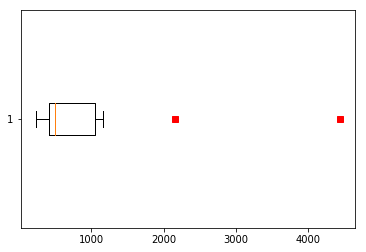

Summe:    10.799
Mean:      1.079


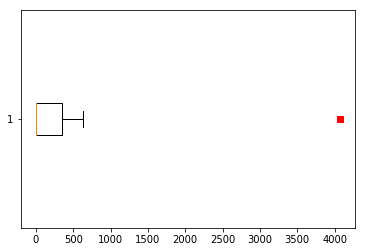

Summe:     5.176
Mean:        517


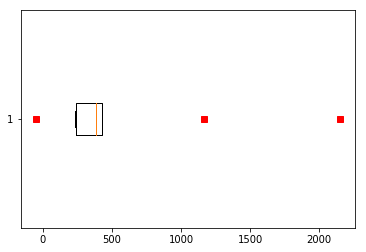

Summe:     5.623
Mean:        562


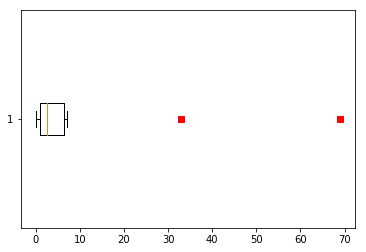

Summe:       122
Mean:         12


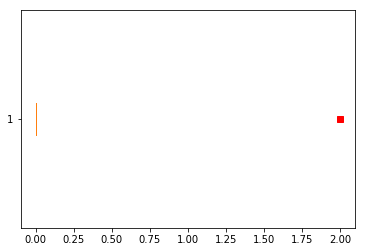

Summe:         2
Mean:          0


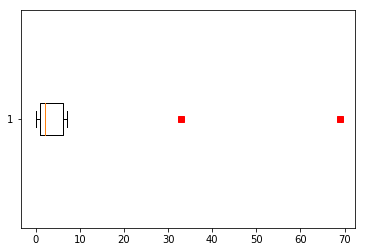

Summe:       120
Mean:         12


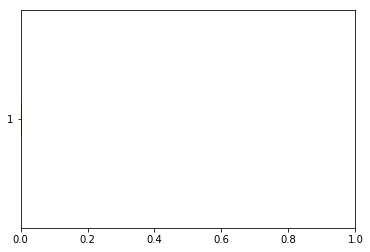

Mean:   0%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:         2 ┬        +2        
2017:         0 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         0 ┬        +0        
2017:         0 ┘      


2018:     4.440 ┬      +366 ( +9%)
2017:     4.074 ┘      


2018:         0 ┬        +0        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       708 ┬      +233 (+49%)
2017:       475 ┘      


2018:         5 ┬        +3 (+150%)
2017:         2 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       428 ┬      +428        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       410 ┬      +410        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.151 ┬    +2.151        
2017:         0 ┘      


2018:        69 ┬       +69        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     1.164 ┬    +1.164        
2017:         0 ┘      


2018:        33 ┬       +33        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       232 ┬      +232        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       425 ┬      +425        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       576 ┬       -51 ( -8%)
2017:       627 ┘      


2018:         4 ┬        +4        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       265 ┬      +265        
2017:         0 ┘      


2018:         7 ┬        +7        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

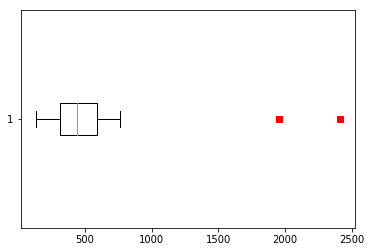

Summe:     8.934
Mean:        687


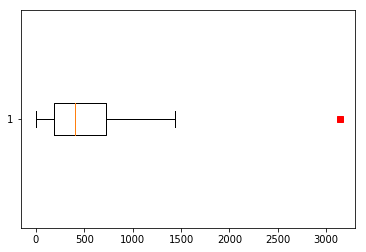

Summe:     8.837
Mean:        679


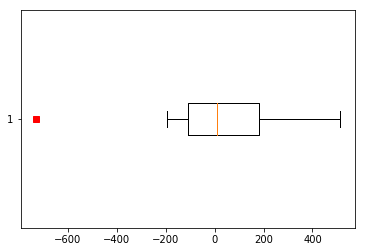

Summe:        97
Mean:          7


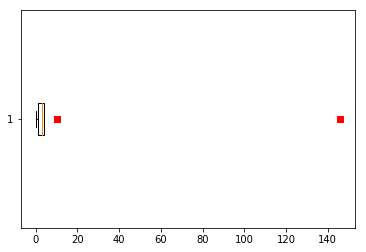

Summe:       184
Mean:         14


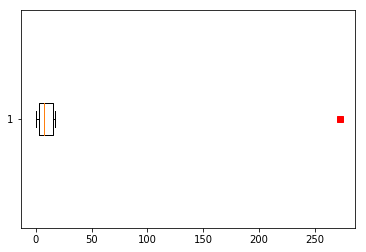

Summe:       366
Mean:         28


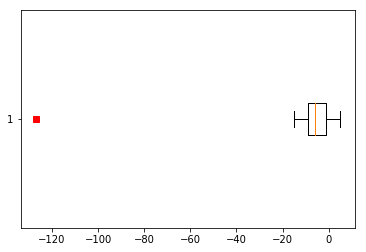

Summe:      -182
Mean:        -14


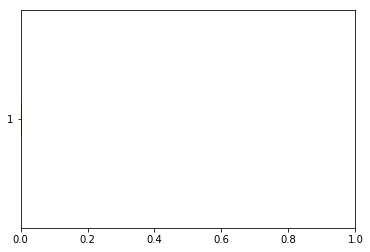

Mean:   0%


Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum 

2018:         4 ┬        -1 (-20%)
2017:         5 ┘      


Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum

2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


2018:     1.956 ┬      +513 (+36%)
2017:     1.443 ┘      


2018:         0 ┬        -1 (-100%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       594 ┬      -130 (-18%)
2017:       724 ┘      


2018:         4 ┬        -3 (-43%)
2017:         7 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       767 ┬       -75 ( -9%)
2017:       842 ┘      


2018:        10 ┬        -7 (-41%)
2017:        17 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       171 ┬      +171        
2017:         0 ┘      


2018:         1 ┬        +1        
2017:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       389 ┬      +198 (+104%)
2017:       191 ┘      


2018:         3 ┬        -9 (-75%)
2017:        12 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       443 ┬      +259 (+141%)
2017:       184 ┘      


2018:         3 ┬       -12 (-80%)
2017:        15 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       132 ┬       +24 (+22%)
2017:       108 ┘      


2018:         0 ┬        -6 (-100%)
2017:         6 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       458 ┬      -196 (-30%)
2017:       654 ┘      


2018:         2 ┬       -15 (-88%)
2017:        17 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       285 ┬       -20 ( -7%)
2017:       305 ┘      


2018:         4 ┬        +3 (+300%)
2017:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       418 ┬      -107 (-20%)
2017:       525 ┘      


2018:         0 ┬        -9 (-100%)
2017:         9 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:     2.414 ┬      -730 (-23%)
2017:     3.144 ┘      


2018:       146 ┬      -127 (-47%)
2017:       273 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       591 ┬      +181 (+44%)
2017:       410 ┘      


2018:        10 ┬        +5 (+100%)
2017:         5 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2018:       316 ┬        +9 ( +3%)
2017:       307 ┘      


2018:         1 ┬        -2 (-67%)
2017:         3 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

In [73]:
def report(node, level=1):
    h(("=" * level) + " " + node["name"] +  " " + ("=" * level), level,hid=node["name"])
    
    if len(node["children"]) > 0 and level <= 2:
        h("Artikel + Unterartikel: Seitenaufrufe 2018", 6)
        v1 = collect(views_new, node)
        plt.boxplot(v1, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(v1)))
        print("Mean:  %s" % d(np.mean(v1)))
        
        h("Artikel + Unterartikel: Seitenaufrufe 2017", 6)
        v2 = collect(views_old, node)
        plt.boxplot(v2, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(v2)))
        print("Mean:  %s" % d(np.mean(v2)))
        
        h("Artikel + Unterartikel: Differenz Seitenaufrufe 2018 zu 2017", 6)
        wd = collect(views_diff, node)
        plt.boxplot(wd, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(wd)))
        print("Mean:  %s" % d(np.mean(wd)))
        
        h("Artikel + Unterartikel: Bearbeitungen 2018", 6)
        v1 = collect(revs_new, node)
        plt.boxplot(v1, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(v1)))
        print("Mean:  %s" % d(np.mean(v1)))
        
        h("Artikel + Unterartikel: Bearbeitungen 2017", 6)
        v2 = collect(revs_old, node)
        plt.boxplot(v2, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(v2)))
        print("Mean:  %s" % d(np.mean(v2)))
        
        h("Artikel + Unterartikel: Differenz Bearbeitungen 2018 zu 2017", 6)
        wd = collect(revs_diff, node)
        plt.boxplot(wd, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(wd)))
        print("Mean:  %s" % d(np.mean(wd)))
        
        h("Artikel + Unterartikel: Quotient Seitenaufrufe MFNF / Wikipedia", 6)
        wd_quot = collect(wp_quot_new, node)
        plt.boxplot(wd_quot, 0, "rs", 0)
        plt.xlim((0,1))
        plt.show()
        
        print("Mean: %3.0f%%" % (100*np.mean(wd_quot)))
        
    
    if len(node["children"]) > 0 and level <= 2:
        a1 = collect_authors(authors_new, node)
        a2 = collect_authors(authors_old, node)

        h("Anzahl Autor*innen (Artikel + Unterartikel)", 5)
        display_markdown("Autor*in haben mehr als 12 Bearbeitungen im betrachteten Zeitraum ")

        v1 = len([k for k,v in a1.items() if v >= 12])
        v2 = len([k for k,v in a2.items() if v >= 12])

        print("2018: %s ┬ %s %s" % (d(v1), diff(v1,v2), quot(v1,v2)))
        print("2017: %s ┘      " %  d(v2))

        h("Anzahl sehr aktive Autor*innen (Artikel + Unterartikel)", 5)
        display_markdown("Autor*in haben mehr als 120 Bearbeitungen im betrachteten Zeitraum")

        v1 = len([k for k,v in a1.items() if v >= 120])
        v2 = len([k for k,v in a2.items() if v >= 120])

        print("2018: %s ┬ %s %s" % (d(v1), diff(v1,v2), quot(v1,v2)))
        print("2017: %s ┘      " %  d(v2))
    
    if "link" in node and node["link"]:
        h("Seitenaufrufe des Artikels '%s'" % node["link"], 5)
        
        v1 = views_new(node)
        v2 = views_old(node)
        
        print("2018: %s ┬ %s %s" % (d(v1), diff(v1,v2), quot(v1,v2)))
        print("2017: %s ┘      " %  d(v2))
        
        h("Bearbeitungen im Artikel '%s'" % node["link"], 5)
        
        v1 = revs_new(node)
        v2 = revs_old(node)
        
        print("2018: %s ┬ %s %s" % (d(v1), diff(v1,v2), quot(v1,v2)))
        print("2017: %s ┘      " %  d(v2))
        
        w = wp_title(node)
        
        if w:
            h("Vergleich der Seitenaufrufe zum Wikipedia-Artikel", 5)
            
            wp1 = wp_new(node)
            wp2 = wp_old(node)
            
            print("Wikipedia-Artikel: %s" % w)
            print("Views 2018:  %s ┬ %s %s" % (d(wp1), diff(wp1,wp2), quot(wp1,wp2)))
            print("Views 2017:  %s ┘      " %  d(wp2))
            print()
            print("MFNF / Wikipedia – 2018: %3.0f%%" % (wp_quot_new(node)*100))
            print("MFNF / Wikipedia – 2017: %3.0f%%" % (wp_quot_old(node)*100))
    
    display_markdown("[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)")
    
    for child in node["children"]:
        report(child, level+1)

report(sitemap)

In [67]:
a1 = collect_authors(authors_new, sitemap)
a2 = collect_authors(authors_old, sitemap)

h("Top-Bearbeiter 2018", 1)

for k,v in sorted(a1.items(), key=lambda x: x[1], reverse=True):
    if v >= 12:
        print(k, v)
        
h("Top-Bearbeiter 2017", 1)

for k,v in sorted(a2.items(), key=lambda x: x[1], reverse=True):
    if v >= 12:
        print(k, v)

Stephan Kulla 896
Jürgen-Michael Glubrecht 337
Michael D'Erchie 309
Aurelia Bröskamp 214
Zornsches Lemma 202
Matheoldie 196
Who2010 167
EmmaBrink 131
Richard4321 86
Sonja Weiland 76
Morpurgo10 60
EulerschesPi 58
Claudia4 57
Weltkäfer 53
Ch1nie 51
Sophie Atzpodien 45
Chris.brand 43
Christian Ivicevic 42
Paulk96 38
Modronomiesatz 29
Guido1234 27
Stefanhuber1993 23
David235134 22
86.56.19.27 22
Malakeks 20
84.143.243.130 19
Fabian Wietschorke 17
Postolus 17
MJ Studies 17
Valentin Roland 16
Naturseptime 15
82.212.29.179 14
84.143.244.158 14
Tzeh 12
Maths CA 12


Stephan Kulla 1424
Auswahlaxiom 1059
Matheoldie 825
Who2010 316
EulerschesPi 126
0-Brane 99
Ch1nie 94
Claudia4 90
Morpurgo10 86
Taschee 81
Phoible 73
SerloBot 70
Richard4321 56
Mathpro01 35
Michael D'Erchie 33
Agnessa power 28
SamuelLippl12345 27
JennKi 26
Einhalbmvquadrat 25
Meitnerium266 24
Fabian Wietschorke 16
Sven87a 16
Lukasstockner 15
BenniSERLO 15
Mattlocke2.0 15
138.246.2.236 15
Benjamin Wolba 14
Vpt93 14
KatharinaKircher 13
2001:A61:10DE:1:34DE:34B5:AB73:C28F 13
